In [1]:
import timm

In [ ]:
from PIL import Image
from torchvision import transforms
import torch
import numpy as np


ModuleNotFoundError: No module named 'matplotlib'

In [4]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): GluMlp(
        (fc1): Linear(in_features=1536, out_features=8192, bias=True)
        (act): SiLU()
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
    

In [13]:
img_path = "/cwStorage/nodecw_group/jijh/hest_output/MEND71_tiles/MEND71_10330_10051.png"

transform = transforms.Compose(
    [
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

In [24]:
ori_input = Image.open(img_path).convert("RGB")
sample_input = transform(Image.open(img_path).convert("RGB")).unsqueeze(0)


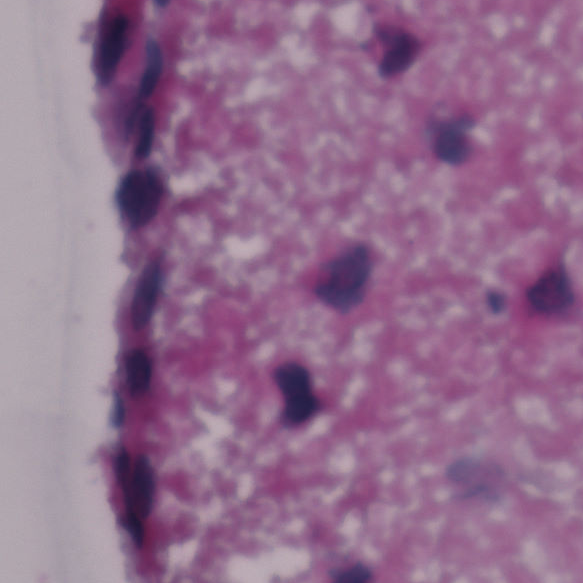

In [25]:
ori_input

In [17]:
np.array(sample_input).shape

/tmp/ipykernel_92307/979172075.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.array(sample_input).shape


(1, 3, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6505601..1.3502399].


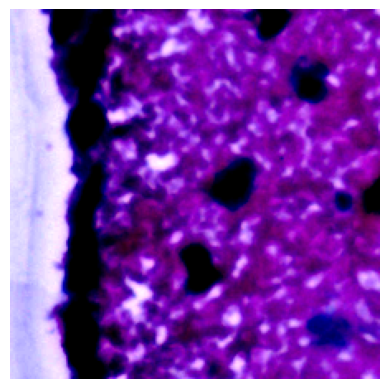

In [18]:
# Visualize the input image
import matplotlib.pyplot as plt

plt.imshow(np.transpose(sample_input.squeeze().numpy(), (1, 2, 0)))
plt.axis("off")
plt.show()

In [15]:
sample_input

tensor([[[[ 0.8447,  0.8618,  0.8618,  ...,  0.7419,  0.9132,  0.9474],
          [ 0.8447,  0.8447,  0.8618,  ...,  0.6906,  0.8618,  0.9132],
          [ 0.8447,  0.8447,  0.8447,  ...,  0.6906,  0.7591,  0.8276],
          ...,
          [ 0.8447,  0.8276,  0.8276,  ...,  0.6049,  0.5878,  0.5707],
          [ 0.8618,  0.8447,  0.8276,  ...,  0.5878,  0.5707,  0.5364],
          [ 0.8618,  0.8276,  0.8447,  ...,  0.6734,  0.6221,  0.5536]],

         [[ 0.8179,  0.8354,  0.8004,  ...,  0.4328,  0.5728,  0.6779],
          [ 0.8179,  0.8354,  0.8004,  ...,  0.3803,  0.5028,  0.6254],
          [ 0.8179,  0.8179,  0.8004,  ...,  0.2752,  0.3978,  0.5203],
          ...,
          [ 0.7829,  0.7829,  0.8004,  ...,  0.1001,  0.0126, -0.0224],
          [ 0.8004,  0.8004,  0.8004,  ...,  0.1702,  0.0826,  0.0301],
          [ 0.8179,  0.8004,  0.8179,  ...,  0.2402,  0.1352,  0.0826]],

         [[ 1.1934,  1.1759,  1.1759,  ...,  0.9842,  1.0365,  1.0888],
          [ 1.1934,  1.1759,  

In [21]:
model.eval()

with torch.no_grad():
    output = model(sample_input)

In [23]:
output.shape

torch.Size([1, 1536])

# Test for classification

In [2]:
import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import scanpy as sc
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [3]:
# 检查是否有 GPU 可用
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:1


In [4]:


# 您提供的 CustomDataset 类
class CustomDataset(Dataset):
    def __init__(self, data_dir):
        # 数据根目录
        self.data_dir = data_dir
        
        # 获取所有以 '_tiles' 结尾的文件夹
        self.tiles_folders = [f for f in os.listdir(data_dir) if f.endswith('_tiles')]
        
        # 从文件夹名称中提取样本编号作为标签
        self.labels = [f.split('_')[0] for f in self.tiles_folders]
        
        # 获取唯一的样本编号并创建整数映射
        self.unique_labels = list(set(self.labels))
        self.label_to_int = {label: i for i, label in enumerate(self.unique_labels)}
        
        # 收集所有图像路径和对应的标签
        self.image_paths = []
        self.image_labels = []
        for folder, label in zip(self.tiles_folders, self.labels):
            folder_path = os.path.join(data_dir, folder)
            # 假设图像文件格式为 .jpg 或 .png
            images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) 
                      if img.endswith('.jpg') or img.endswith('.png')]
            self.image_paths.extend(images)
            self.image_labels.extend([self.label_to_int[label]] * len(images))
        
        # 定义图像转换操作
        self.transform = transforms.Compose([
            transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])
    
    def __len__(self):
        # 返回数据集中的图像总数
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # 根据索引获取图像路径和标签
        img_path = self.image_paths[idx]
        label = self.image_labels[idx]
        
        # 加载图像并转换为 RGB 格式
        image = Image.open(img_path).convert('RGB')
        
        # 应用转换操作
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def get_label_name(self, label_int):
        # 根据整数标签返回原始样本编号
        return self.unique_labels[label_int]

# 加载数据集
data_dir = '/cwStorage/nodecw_group/jijh/hest_output'
dataset = CustomDataset(data_dir)



In [5]:
# 随机抽取图像
num_samples = 8000  # 可调整的抽样数量
indices = random.sample(range(len(dataset)), num_samples)
subset = Subset(dataset, indices)
dataloader = DataLoader(subset, batch_size=128, shuffle=False, num_workers=16)  # 使用多线程加速

In [2]:
import timm

# 创建模型
model = timm.create_model(
    model_name='hf_hub:prov-gigapath/prov-gigapath',
    pretrained=True,
    cache_dir='/home1/jijh/diffusion_project/huggingface_repo/prov-gigapath'
)

In [3]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): GluMlp(
        (fc1): Linear(in_features=1536, out_features=8192, bias=True)
        (act): SiLU()
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
    

In [8]:
from tqdm import tqdm

# Move model to the specified device and set to evaluation mode
model = model.to(device)
model.eval()

# Get embeddings and labels
embeddings = []
labels = []

# Import tqdm for progress tracking

with torch.no_grad():
    # Use tqdm to show progress
    for images, batch_labels in tqdm(dataloader, desc="Extracting embeddings"):
        # Move data to device
        images = images.to(device)
        
        # Model inference
        outputs = model(images)
        
        # Move results back to CPU and convert to numpy
        embeddings.append(outputs.cpu().numpy())
        labels.append(batch_labels.numpy())  # No need to move labels to device and back

# Concatenate results
embeddings = np.concatenate(embeddings, axis=0)  # [num_samples, embedding_dim]
labels = np.concatenate(labels, axis=0)          # [num_samples]

print(f"Generated embeddings shape: {embeddings.shape}")
print(f"Labels shape: {labels.shape}")

Extracting embeddings: 100%|██████████| 63/63 [02:07<00:00,  2.02s/it]

Generated embeddings shape: (8000, 1536)
Labels shape: (8000,)


In [14]:
adata = sc.AnnData(X=embeddings, obs={"labels": labels})

In [17]:
sc.settings.verbosity = 3

In [ ]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca')
sc.tl.umap(adata)
sc.tl.leiden(adata)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:21)


ImportError: Please install the igraph package: `conda install -c conda-forge python-igraph` or `pip3 install igraph`.

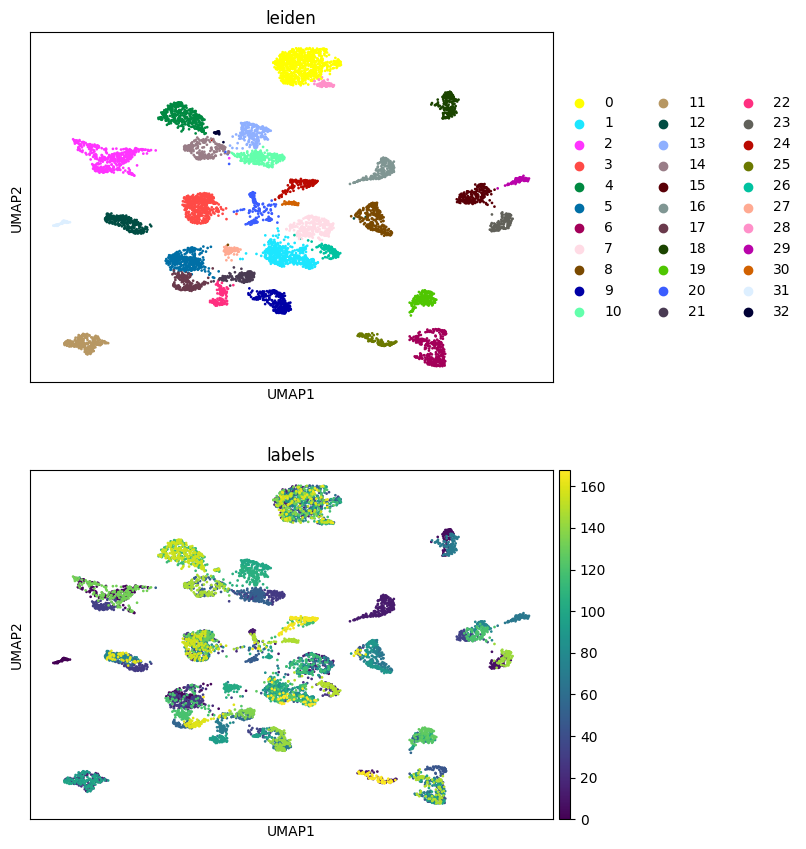

In [25]:
sc.pl.umap(adata, color=['leiden', 'labels'], ncols=1)

In [24]:
sc.tl.leiden(adata)

running Leiden clustering


/tmp/ipykernel_124739/3467744858.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


    finished: found 33 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


In [35]:
sc.tl.louvain(adata)

running Louvain clustering


ModuleNotFoundError: No module named 'louvain'

In [28]:
leiden_labels = adata.obs['leiden'].astype(int).values
umap_embeddings = adata.obsm['X_umap']

In [39]:
silhouette_umap = silhouette_score(adata.obsm['X_umap'], adata.obs['labels'])

In [40]:
silhouette_umap

np.float32(-0.0056311013)

In [9]:
# 降维
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)



In [10]:
# UMAP
import umap.umap_ as umap
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

/public/home/jijh/micromamba/envs/gigapath/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
silhouette_tsne = silhouette_score(tsne_embeddings, labels)

In [38]:
silhouette_tsne

np.float32(0.039736725)

In [33]:
# Adjusted Rand Index（衡量聚类与原始标签的一致性）
ari_leiden = adjusted_rand_score(labels, leiden_labels)
# ari_umap = adjusted_rand_score(labels, leiden_labels_umap)
print(f"Adjusted Rand Index (t-SNE vs Leiden): {ari_leiden:.3f}")
# print(f"Adjusted Rand Index (UMAP vs Leiden): {ari_umap:.3f}")

Adjusted Rand Index (t-SNE vs Leiden): 0.373


# Compare to vae

In [42]:
from diffusers import AutoencoderTiny

def get_vae_model(sample_size=512, latent_channels=4, use_pretrained=False, sd_version='v2.1'):
    """
    获取 VAE 模型。
      - use_pretrained=True（默认）：加载预训练的 Tiny AutoEncoder 模型（保持参数为 FP32）。
          sd_version: 'v2.1'（默认）加载适用于 Stable Diffusion v2.1 的 Tiny AutoEncoder，
                      若设置为 'sdxl' 则加载适用于 SDXL 的版本。
      - use_pretrained=False：从头构造新的 Tiny AutoEncoder 模型（采用 TAESD 默认配置）。
    """
    if use_pretrained:
        if sd_version == 'v2.1':
            vae = AutoencoderTiny.from_pretrained("madebyollin/taesd", torch_dtype=torch.float32)
        elif sd_version == 'sdxl':
            vae = AutoencoderTiny.from_pretrained("madebyollin/taesdxl", torch_dtype=torch.float32)
        else:
            raise ValueError("sd_version 需为 'v2.1' 或 'sdxl'")
        print("Loaded pretrained Tiny AutoEncoder model.")
    else:
        # 从头构造 Tiny AutoEncoder 模型，参数取自 TAESD 默认设置
        vae = AutoencoderTiny(
            in_channels=3,
            out_channels=3,
            encoder_block_out_channels=(64, 64, 64, 64),
            decoder_block_out_channels=(64, 64, 64, 64),
            act_fn="relu",
            latent_channels=latent_channels,
            upsampling_scaling_factor=2,
            num_encoder_blocks=(1, 3, 3, 3),
            num_decoder_blocks=(3, 3, 3, 1),
            latent_magnitude=3.0,
            latent_shift=0.5,
            force_upcast=False,
            scaling_factor=1.0,
            shift_factor=0.0
        )
        print("Created new Tiny AutoEncoder model from scratch.")
    return vae


# 加载 VAE 模型，并加载预训练参数（路径请根据实际情况修改）
vae = get_vae_model(use_pretrained=False)
vae_state = torch.load('/cwStorage/nodecw_group/jijh/model_path/vae_epoch_10.pth', map_location='cpu')
vae.load_state_dict(vae_state)
vae.eval()  # 仅用于编码，不参与梯度更新
for param in vae.parameters():
    param.requires_grad = False

Created new Tiny AutoEncoder model from scratch.


In [43]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.tiles_folders = [f for f in os.listdir(data_dir) if f.endswith('_tiles')]
        self.labels = [f.split('_')[0] for f in self.tiles_folders]
        self.unique_labels = list(set(self.labels))
        self.label_to_int = {label: i for i, label in enumerate(self.unique_labels)}
        
        self.image_paths = []
        self.image_labels = []
        for folder, label in zip(self.tiles_folders, self.labels):
            folder_path = os.path.join(data_dir, folder)
            images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) 
                      if img.endswith('.jpg') or img.endswith('.png')]
            self.image_paths.extend(images)
            self.image_labels.extend([self.label_to_int[label]] * len(images))
        
        # 使用 VAE 的数据预处理
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.image_labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def get_label_name(self, label_int):
        return self.unique_labels[label_int]

In [44]:
import random
from torch.utils.data import DataLoader, Subset

data_dir = '/cwStorage/nodecw_group/jijh/hest_output'
dataset = CustomDataset(data_dir)
num_samples = 8000
indices = random.sample(range(len(dataset)), num_samples)
subset = Subset(dataset, indices)
dataloader = DataLoader(subset, batch_size=128, shuffle=False, num_workers=16)

In [50]:
import torch
import numpy as np
from tqdm import tqdm

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

vae = vae.to(device)
vae.eval()

embeddings = []
labels = []

with torch.no_grad():
    for images, batch_labels in tqdm(dataloader, desc="Extracting embeddings"):
        images = images.to(device)
        encoded = vae.encode(images)
        # Access latent embeddings using the 'latents' attribute
        latent_embeddings = encoded.latents  
        
        # Flatten latent embeddings: from [batch_size, latent_channels, H, W] to [batch_size, latent_dim]
        latent_embeddings = latent_embeddings.view(latent_embeddings.size(0), -1)
        embeddings.append(latent_embeddings.cpu().numpy())
        labels.append(batch_labels.numpy())

embeddings = np.concatenate(embeddings, axis=0)  # [num_samples, latent_dim]
labels = np.concatenate(labels, axis=0)          # [num_samples]
print(f"Generated embeddings shape: {embeddings.shape}")
print(f"Labels shape: {labels.shape}")


Using device: cuda:1


Extracting embeddings: 100%|██████████| 63/63 [00:44<00:00,  1.41it/s]


Generated embeddings shape: (8000, 16384)
Labels shape: (8000,)


computing PCA
    with n_comps=50
    finished (0:00:03)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:23)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


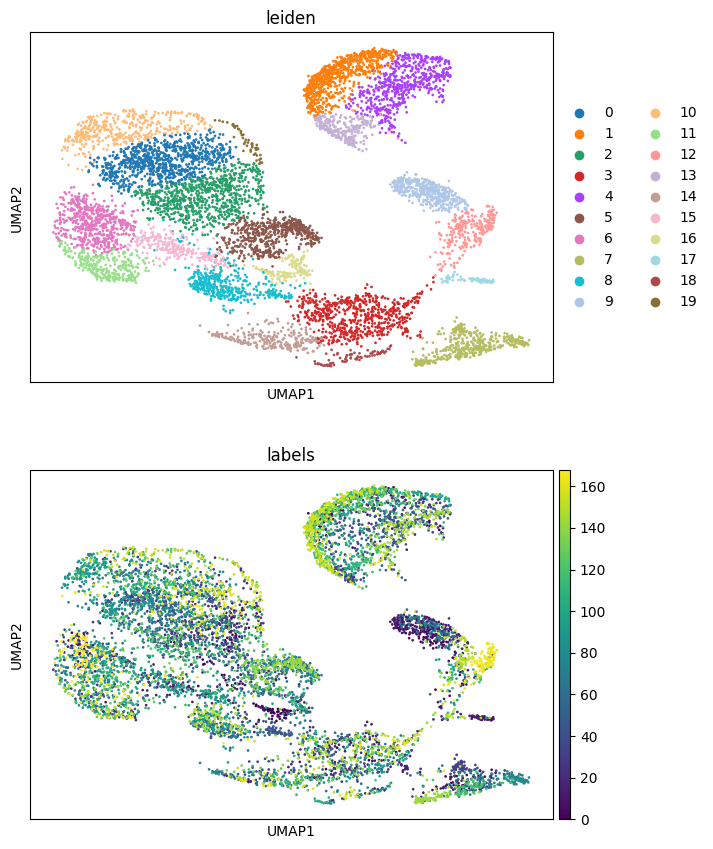

Silhouette Score (UMAP): -0.193
Adjusted Rand Index (Leiden): 0.166


In [51]:
import scanpy as sc
from sklearn.metrics import silhouette_score, adjusted_rand_score

# 创建 AnnData 对象
adata = sc.AnnData(X=embeddings, obs={"labels": labels})

# PCA
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

# 计算邻居
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca')

# UMAP
sc.tl.umap(adata)

# Leiden 聚类
sc.tl.leiden(adata)

# 可视化 UMAP
sc.pl.umap(adata, color=['leiden', 'labels'], ncols=1)

# 计算 silhouette score（基于 UMAP）
silhouette_umap = silhouette_score(adata.obsm['X_umap'], adata.obs['labels'])
print(f"Silhouette Score (UMAP): {silhouette_umap:.3f}")

# 计算 adjusted rand index（Leiden 聚类与真实标签）
leiden_labels = adata.obs['leiden'].astype(int).values
ari_leiden = adjusted_rand_score(labels, leiden_labels)
print(f"Adjusted Rand Index (Leiden): {ari_leiden:.3f}")

In [60]:
adata.obs['label_names'] = [dataset.get_label_name(label) for label in adata.obs['labels']]
adata.obs['label_categorical'] = adata.obs['label_names'].astype('category')


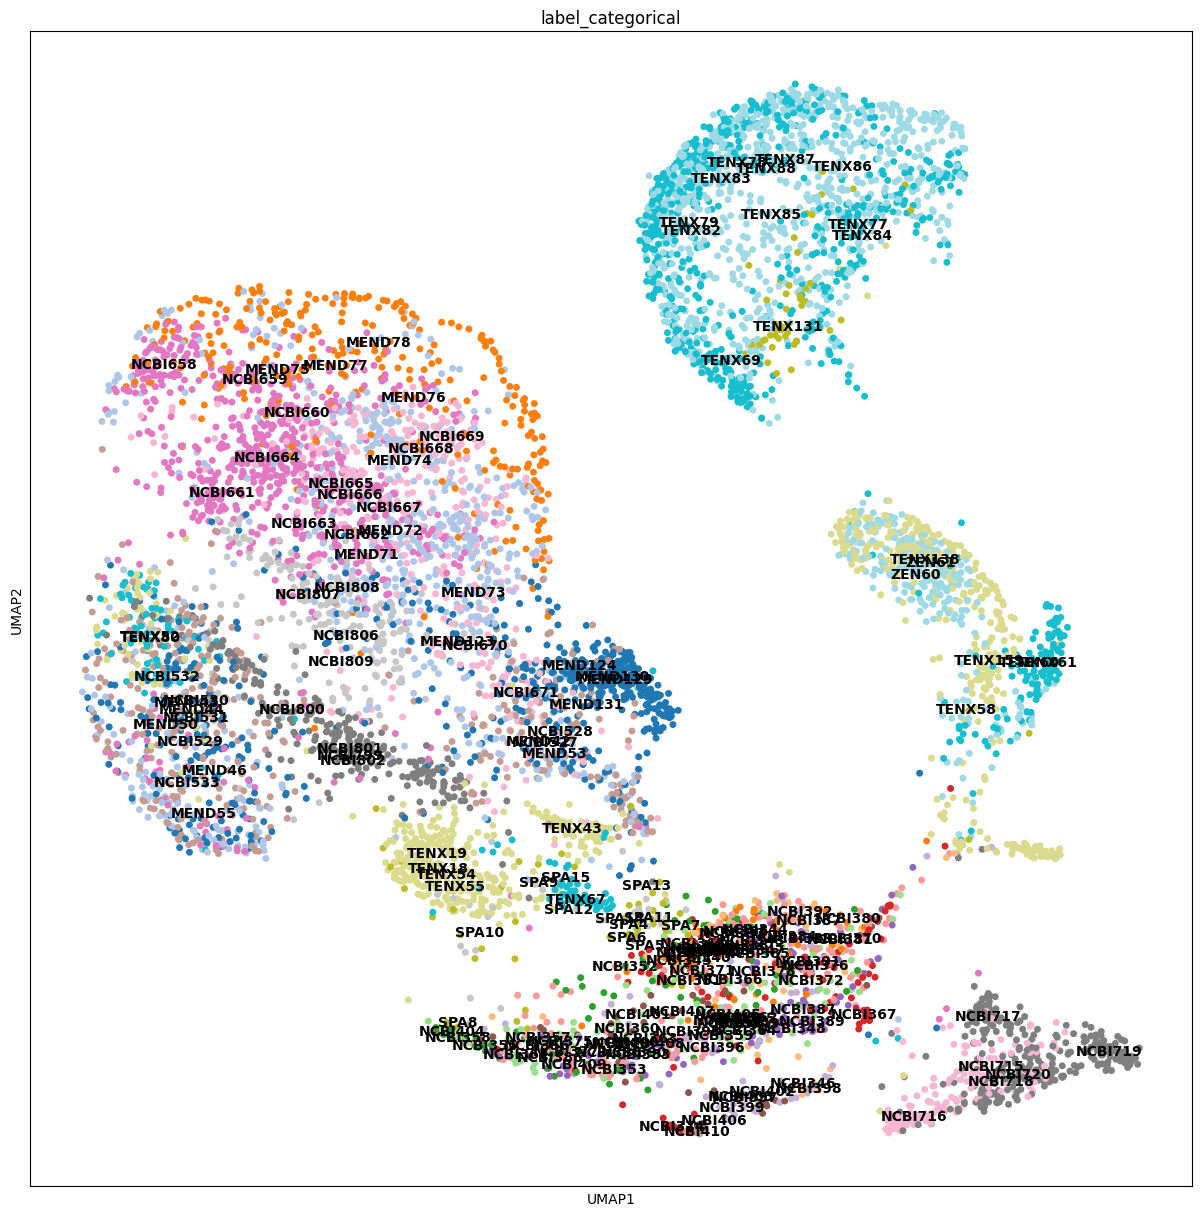

In [61]:
fig, ax = plt.subplots(figsize=(15, 15))
sc.pl.umap(adata, color=['label_categorical'], ncols=1, legend_loc='on data', palette='tab20', ax=ax, size=100)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sc.pl.umap(adata, color=['label_categorical'], ncols=1, legend_loc='on data', palette='tab20', ax=ax, size=100)
plt.show()

# Test gigapath for various samples

In [4]:
import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import scanpy as sc
from sklearn.metrics import silhouette_score, adjusted_rand_score

/public/home/jijh/micromamba/envs/gigapath/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# 检查是否有 GPU 可用
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:1


In [34]:


# 您提供的 CustomDataset 类
class CustomDataset(Dataset):
    def __init__(self, data_dir):
        # 数据根目录
        self.data_dir = data_dir
        
        # 获取所有以 '_tiles' 结尾的文件夹
        self.tiles_folders = [f for f in os.listdir(data_dir) if f.endswith('_tiles')]
        
        # 从文件夹名称中提取样本编号作为标签
        self.labels = [f.split('_')[0] for f in self.tiles_folders]
        
        # 获取唯一的样本编号并创建整数映射
        self.unique_labels = list(set(self.labels))
        self.label_to_int = {label: i for i, label in enumerate(self.unique_labels)}
        
        # 收集所有图像路径和对应的标签
        self.image_paths = []
        self.image_labels = []
        for folder, label in zip(self.tiles_folders, self.labels):
            folder_path = os.path.join(data_dir, folder)
            # 假设图像文件格式为 .jpg 或 .png
            images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) 
                      if img.endswith('.jpg') or img.endswith('.png')]
            self.image_paths.extend(images)
            self.image_labels.extend([self.label_to_int[label]] * len(images))
        
        # 定义图像转换操作
        self.transform = transforms.Compose([
            transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])
    
    def __len__(self):
        # 返回数据集中的图像总数
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # 根据索引获取图像路径和标签
        img_path = self.image_paths[idx]
        label = self.image_labels[idx]
        
        # 加载图像并转换为 RGB 格式
        image = Image.open(img_path).convert('RGB')
        
        # 应用转换操作
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def get_label_name(self, label_int):
        # 根据整数标签返回原始样本编号
        return self.unique_labels[label_int]

# 加载数据集
data_dir = '/cwStorage/nodecw_group/jijh/hest_output'
dataset = CustomDataset(data_dir)



In [36]:
# 随机抽取图像
num_samples = 45000  # 可调整的抽样数量
indices = random.sample(range(len(dataset)), num_samples)
subset = Subset(dataset, indices)
dataloader = DataLoader(subset, batch_size=512, shuffle=False, num_workers=16)  # 使用多线程加速

In [8]:
import timm

# 创建模型
model = timm.create_model(
    model_name='hf_hub:prov-gigapath/prov-gigapath',
    pretrained=True,
    cache_dir='/home1/jijh/diffusion_project/huggingface_repo/prov-gigapath'
)

In [37]:
from tqdm import tqdm

# Move model to the specified device and set to evaluation mode
model = model.to(device)
model.eval()

# Get embeddings and labels
embeddings = []
labels = []

# Import tqdm for progress tracking

with torch.no_grad():
    # Use tqdm to show progress
    for images, batch_labels in tqdm(dataloader, desc="Extracting embeddings"):
        # Move data to device
        images = images.to(device)
        
        # Model inference
        outputs = model(images)
        
        # Move results back to CPU and convert to numpy
        embeddings.append(outputs.cpu().numpy())
        labels.append(batch_labels.numpy())  # No need to move labels to device and back

# Concatenate results
embeddings = np.concatenate(embeddings, axis=0)  # [num_samples, embedding_dim]
labels = np.concatenate(labels, axis=0)          # [num_samples]

print(f"Generated embeddings shape: {embeddings.shape}")
print(f"Labels shape: {labels.shape}")

Extracting embeddings: 100%|██████████| 88/88 [11:46<00:00,  8.03s/it]


Generated embeddings shape: (45000, 1536)
Labels shape: (45000,)


In [38]:
import scanpy as sc
from sklearn.metrics import silhouette_score, adjusted_rand_score

# 创建 AnnData 对象
adata = sc.AnnData(X=embeddings, obs={"labels": labels})



In [39]:
adata.obs['label_names'] = [dataset.get_label_name(label) for label in adata.obs['labels']]
adata.obs['label_categorical'] = adata.obs['label_names'].astype('category')


In [40]:
import pandas as pd
hest_meta = pd.read_csv('/cwStorage/nodecw_group/jijh/hest_1k/HEST_v1_1_0.csv')

In [ ]:
hest_meta

dataset_title       id  \
0     Fresh Frozen Mouse Brain Hemisphere with 5K Mo...  TENX159   
1     FFPE Human Skin Primary Dermal Melanoma with 5...  TENX158   
2     FFPE Human Prostate Adenocarcinoma with 5K Hum...  TENX157   
3     Characterization of immune cell populations in...  TENX156   
4     Characterization of immune cell populations in...  TENX155   
...                                                 ...      ...   
1224                                        spatialLIBD    MISC5   
1225                                        spatialLIBD    MISC4   
1226                                        spatialLIBD    MISC3   
1227                                        spatialLIBD    MISC2   
1228                                        spatialLIBD    MISC1   

     image_filename     organ disease_state oncotree_code       species  \
0       TENX159.tif     Brain       Healthy           NaN  Mus musculus   
1       TENX158.tif      Skin        Cancer          SKCM  Homo sapiens   
2       TENX157.tif  Prostate        Cancer          PRAD  Homo sapiens   
3       TENX156.tif     Bowel        Cancer          COAD  Homo sapiens   
4       TENX155.tif     Bowel        Cancer          COAD  Homo sapiens   
...             ...       ...           ...           ...           ...   
1224      MISC5.tif     Brain       Healthy           NaN  Homo sapiens   
1225      MISC4.tif     Brain       Healthy           NaN  Homo sapiens   
1226      MISC3.tif     Brain       Healthy           NaN  Homo sapiens   
1227      MISC2.tif     Brain       Healthy           NaN  Homo sapiens   
1228      MISC1.tif     Brain       Healthy           NaN  Homo sapiens   

        patient st_technology data_publication_date  ... treatment_comment  \
0           NaN        Xenium               7/31/24  ...               NaN   
1           NaN        Xenium               7/31/24  ...               NaN   
2           NaN        Xenium               7/31/24  ...               NaN   
3     Patient 1     Visium HD               7/11/24  ...               NaN   
4     Patient 1     Visium HD               7/11/24  ...               NaN   
...         ...           ...                   ...  ...               ...   
1224                   Visium                   NaN  ...               NaN   
1225                   Visium                   NaN  ...               NaN   
1226                   Visium                   NaN  ...               NaN   
1227                   Visium                   NaN  ...               NaN   
1228                   Visium                   NaN  ...               NaN   

     pixel_size_um_embedded pixel_size_um_estimated  magnification  \
0                  0.273768                0.274027            40x   
1                  0.273777                0.273754            40x   
2                  0.273772                0.273741            40x   
3                  0.264583                0.273802            40x   
4                  0.264583                0.273874            40x   
...                     ...                     ...            ...   
1224                    NaN                0.727113            20x   
1225                    NaN                0.726109            20x   
1226                    NaN                0.725124            20x   
1227                    NaN                0.726109            20x   
1228                    NaN                0.726109            20x   

      fullres_px_width  fullres_px_height                          tissue  \
0                17051              24689                           Brain   
1                18669              35787                            Skin   
2                25002              49976                        Prostate   
3                71106              58791                           Colon   
4                75250              48740                           Colon   
...                ...                ...                             ...   
1224   

In [41]:
# Create a mapping from the metadata dataframe based on ID
# First, make sure we're working with string IDs in both dataframes
hest_meta['id'] = hest_meta['id'].astype(str)

# Create a dictionary to map sample ID to metadata
metadata_dict = {}
for idx, row in hest_meta.iterrows():
    sample_id = row['id']
    metadata_dict[sample_id] = row.to_dict()
    
# Add metadata columns to adata.obs
# Get list of unique sample IDs in our data
unique_samples = adata.obs['label_names'].unique()

# Add metadata columns
meta_columns = [col for col in hest_meta.columns if col != 'id']

# Initialize with NaN values
for col in meta_columns:
    adata.obs[col] = np.nan

# Fill in metadata where matches are found
for sample_id in unique_samples:
    if sample_id in metadata_dict:
        # For each matching sample, get all rows with that sample ID
        sample_rows = adata.obs['label_names'] == sample_id
        # Add each metadata column
        for col in meta_columns:
            adata.obs.loc[sample_rows, col] = metadata_dict[sample_id][col]

print(f"Added {len(meta_columns)} columns of metadata to AnnData object")
print(f"Found metadata for {sum(adata.obs['label_names'].isin(metadata_dict.keys()))/len(adata.obs)*100:.1f}% of samples")


/tmp/ipykernel_11375/3935207379.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Tertiary lymphoid structures generate and propagate anti-tumor antibody-producing plasma cells in renal cell cancer' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[sample_rows, col] = metadata_dict[sample_id][col]
/tmp/ipykernel_11375/3935207379.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'INT8.tif' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[sample_rows, col] = metadata_dict[sample_id][col]
/tmp/ipykernel_11375/3935207379.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Kidney' has dtype incompatible with float64, please explici

Added 27 columns of metadata to AnnData object
Found metadata for 100.0% of samples


In [42]:
adata

AnnData object with n_obs × n_vars = 45000 × 1536
    obs: 'labels', 'label_names', 'label_categorical', 'dataset_title', 'image_filename', 'organ', 'disease_state', 'oncotree_code', 'species', 'patient', 'st_technology', 'data_publication_date', 'license', 'study_link', 'download_page_link1', 'inter_spot_dist', 'spot_diameter', 'spots_under_tissue', 'preservation_method', 'nb_genes', 'treatment_comment', 'pixel_size_um_embedded', 'pixel_size_um_estimated', 'magnification', 'fullres_px_width', 'fullres_px_height', 'tissue', 'disease_comment', 'subseries', 'hest_version_added'

In [43]:
sc.settings.verbosity = 3

computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:49)
running Leiden clustering
    finished: found 70 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:39)


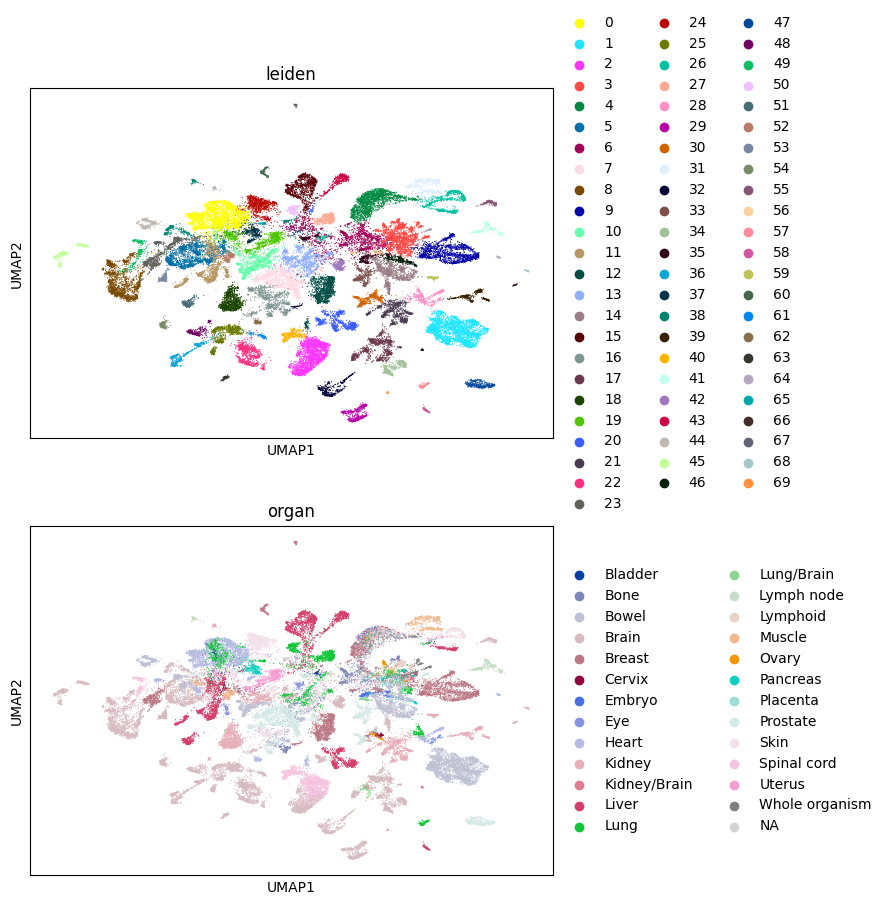

ValueError: Input contains NaN

In [ ]:
# PCA
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

# 计算邻居
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca')

# UMAP
sc.tl.umap(adata)

# Leiden 聚类
sc.tl.leiden(adata)

# 可视化 UMAP
sc.pl.umap(adata, color=['leiden', 'organ'], ncols=1)



In [46]:
# Calculate silhouette score (based on UMAP embeddings)
# Filter out NaN values in the organ column
mask = adata.obs['organ'].notna()
if mask.sum() > 0:  # Make sure we have enough valid values
    silhouette_umap = silhouette_score(adata.obsm['X_umap'][mask], adata.obs['organ'][mask])
    print(f"Silhouette Score (UMAP): {silhouette_umap:.3f}")
else:
    print("Cannot calculate silhouette score: too many missing values in 'organ' column")

# Calculate adjusted rand index (Leiden clustering vs true labels)
# Handle categorical data properly
if mask.sum() > 0:
    leiden_labels = adata.obs['leiden'].astype(int).values[mask]
    organ_labels = adata.obs['organ'][mask].astype('category').cat.codes
    ari_leiden = adjusted_rand_score(organ_labels, leiden_labels)
    print(f"Adjusted Rand Index (Leiden vs Organ): {ari_leiden:.3f}")
else:
    print("Cannot calculate ARI: too many missing values in 'organ' column")

Silhouette Score (UMAP): -0.366
Adjusted Rand Index (Leiden vs Organ): 0.217


In [47]:
adata

AnnData object with n_obs × n_vars = 45000 × 1536
    obs: 'labels', 'label_names', 'label_categorical', 'dataset_title', 'image_filename', 'organ', 'disease_state', 'oncotree_code', 'species', 'patient', 'st_technology', 'data_publication_date', 'license', 'study_link', 'download_page_link1', 'inter_spot_dist', 'spot_diameter', 'spots_under_tissue', 'preservation_method', 'nb_genes', 'treatment_comment', 'pixel_size_um_embedded', 'pixel_size_um_estimated', 'magnification', 'fullres_px_width', 'fullres_px_height', 'tissue', 'disease_comment', 'subseries', 'hest_version_added', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'organ_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

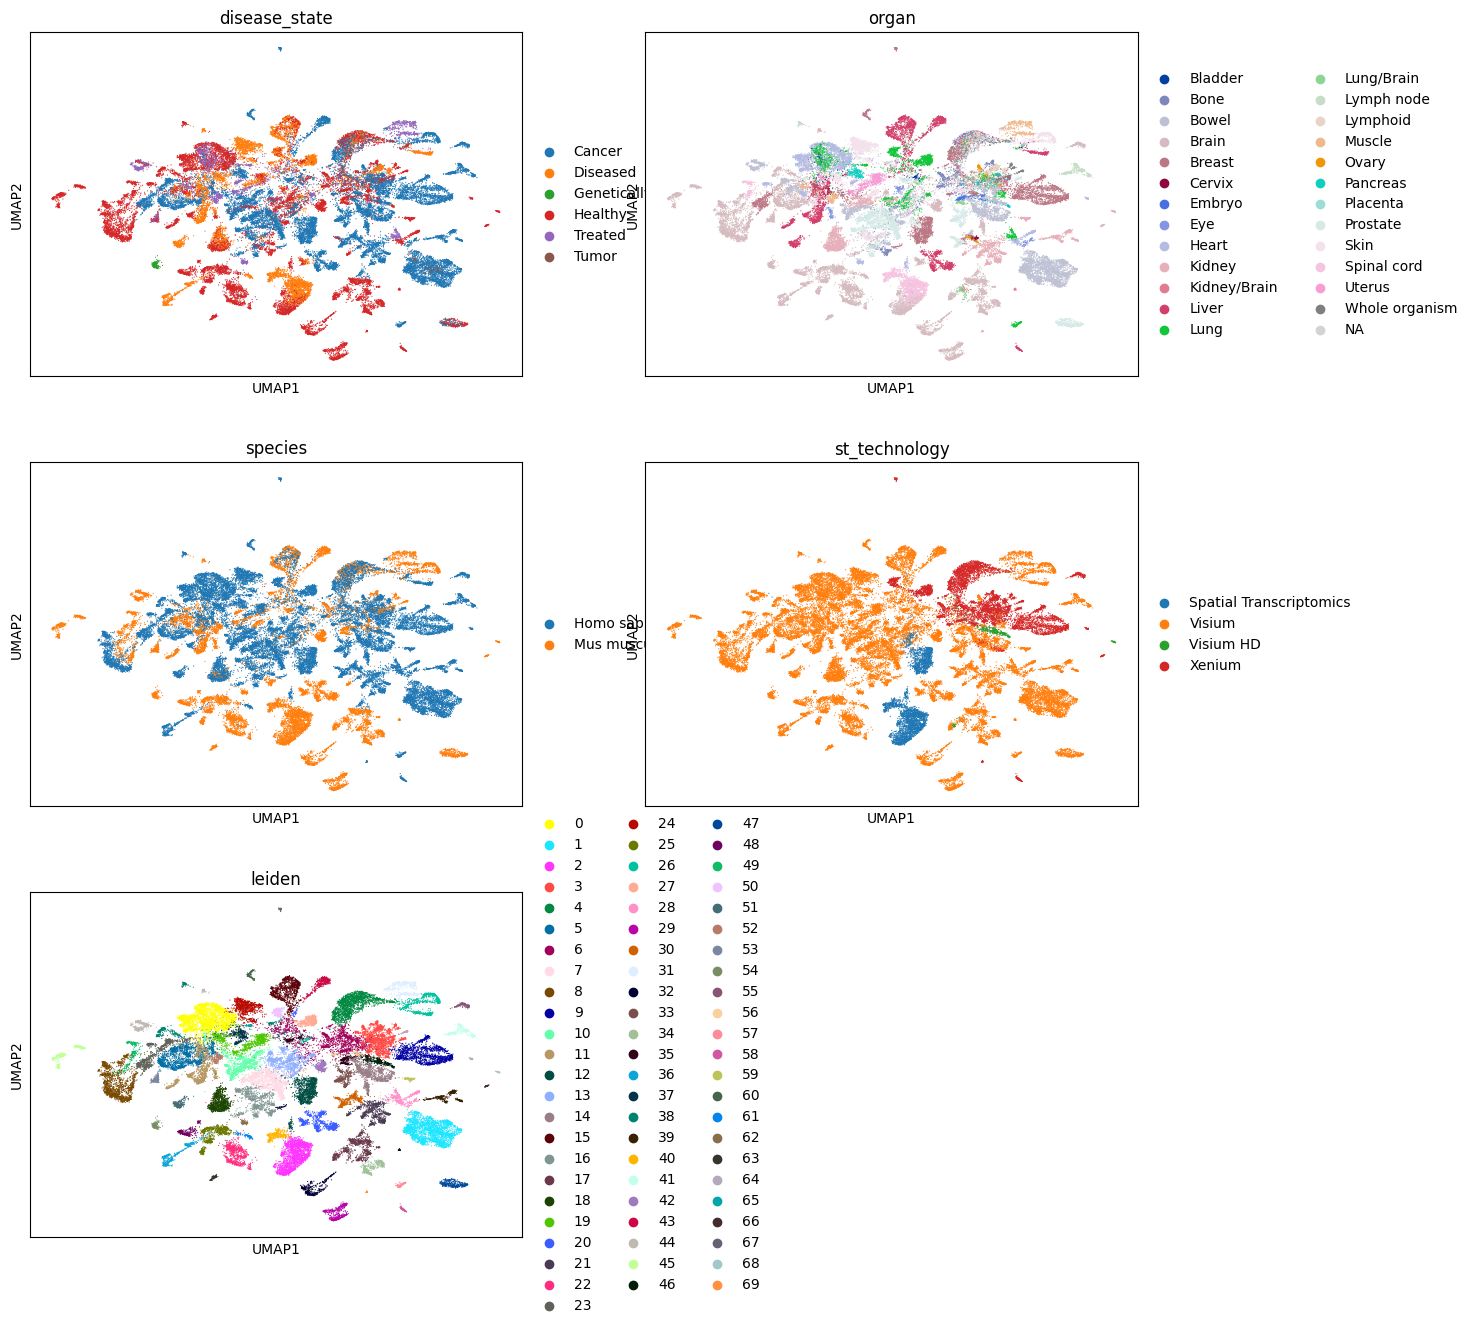

In [48]:
sc.pl.umap(adata, color=['disease_state', 'organ', 'species', 'st_technology', 'leiden'], ncols=2)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:38)
running Leiden clustering
    finished: found 98 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:12)


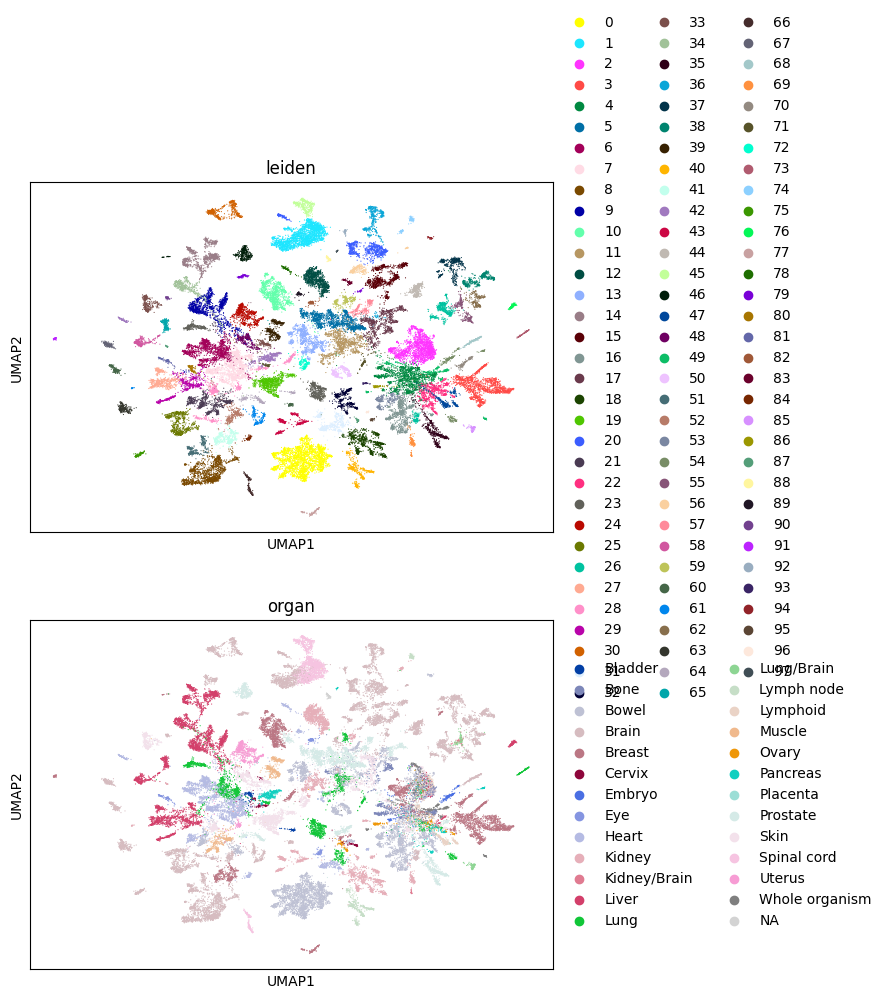

In [49]:
# Test for using the whole features


# 计算邻居
sc.pp.neighbors(adata, use_rep='X')

# UMAP
sc.tl.umap(adata)
adata.obsm['X_umap_whole'] = adata.obsm['X_umap']

# Leiden 聚类
sc.tl.leiden(adata)
adata.obs['leiden_whole'] = adata.obs['leiden']

# 可视化 UMAP
sc.pl.umap(adata, color=['leiden', 'organ'], ncols=1)



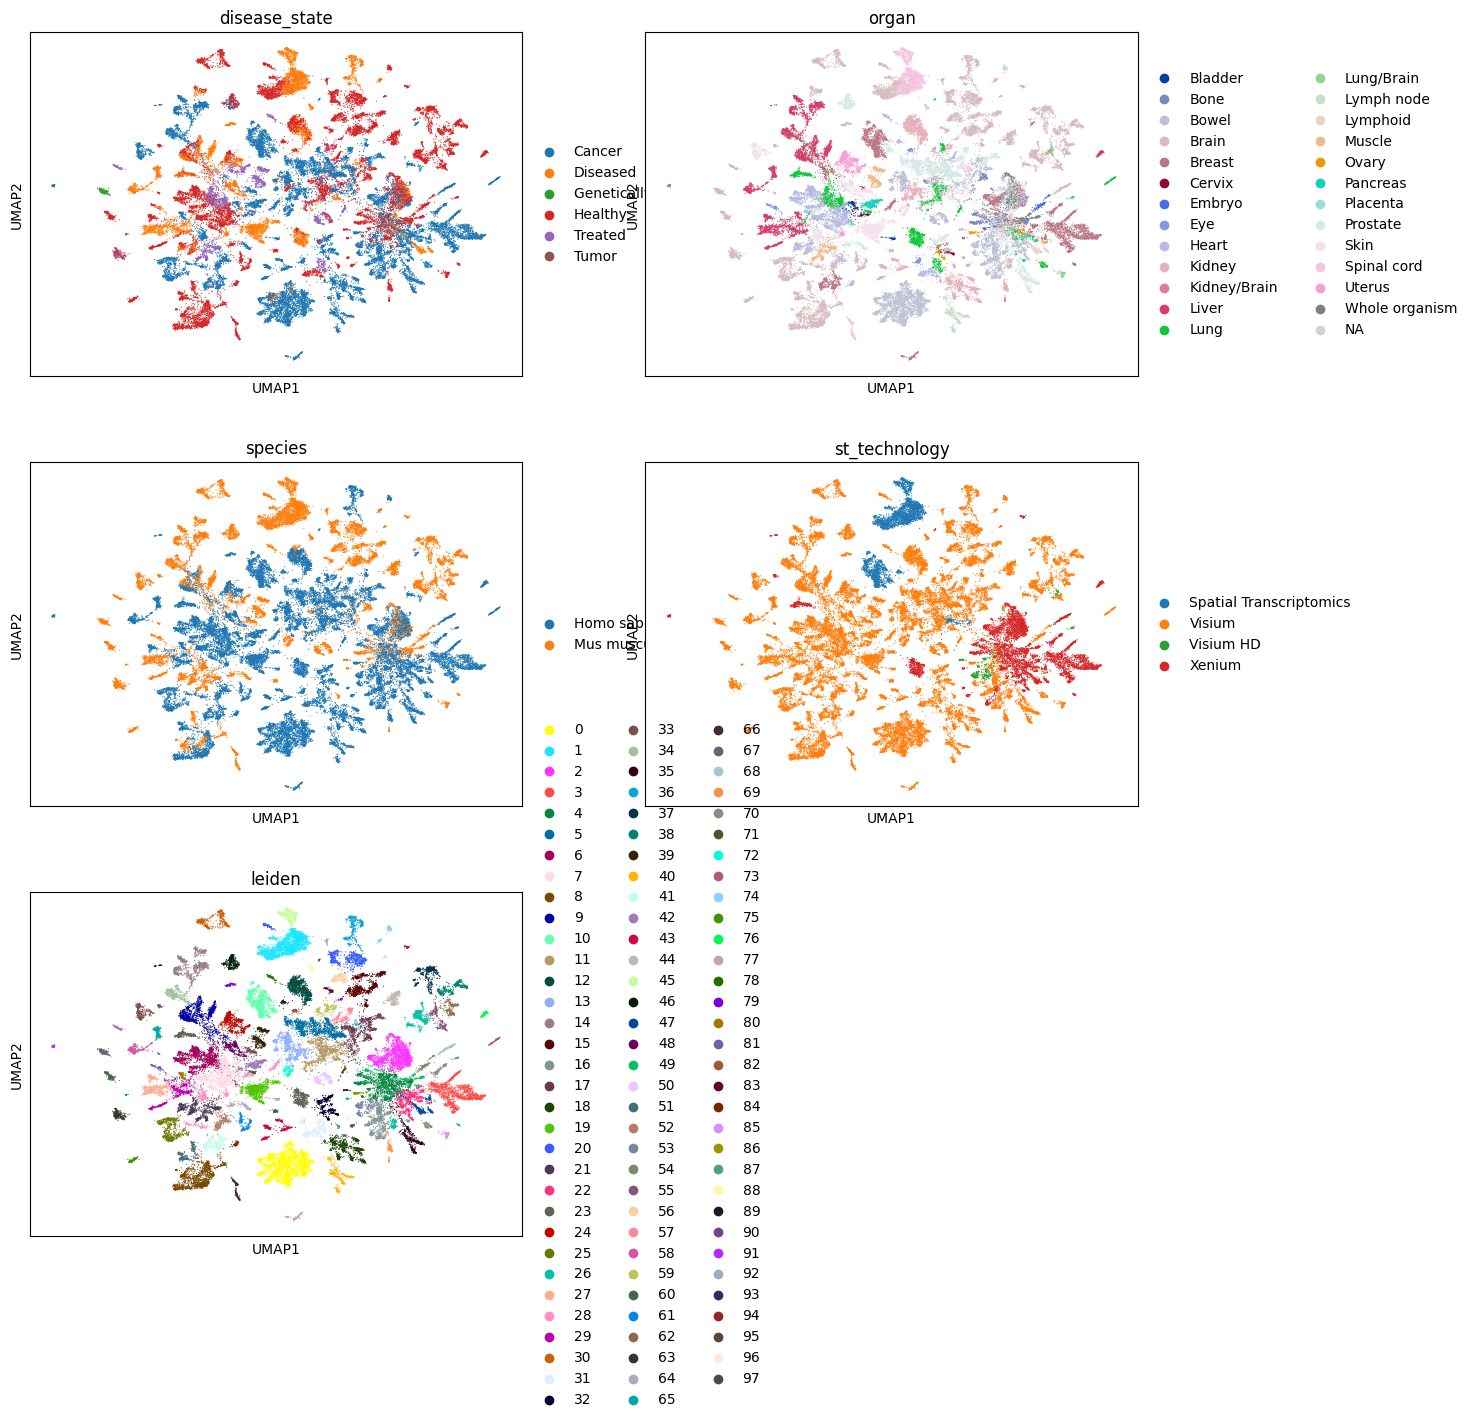

In [50]:
sc.pl.umap(adata, color=['disease_state', 'organ', 'species', 'st_technology', 'leiden'], ncols=2)

In [30]:
# Calculate Adjusted Rand Index (ARI) for different metadata columns
metadata_columns = ['organ', 'disease_state', 'species', 'st_technology', 'labels']
leiden_labels = adata.obs['leiden'].astype(int).values

# Loop through columns and calculate ARI if the column has valid values
print("Adjusted Rand Index between Leiden clusters and metadata categories:")
for col in metadata_columns:
    # Check if column exists and has enough non-NaN values
    if col in adata.obs.columns and adata.obs[col].notna().sum() > 0:
        # Convert categorical column to numeric codes
        col_labels = adata.obs[col].astype('category').cat.codes
        # Exclude -1 values (which represent NaN)
        mask = col_labels != -1
        if mask.sum() > 0:
            # Calculate ARI only on valid values
            ari = adjusted_rand_score(col_labels[mask], leiden_labels[mask])
            print(f"  {col}: {ari:.3f}")
        else:
            print(f"  {col}: Not enough valid values")
    else:
        print(f"  {col}: Column missing or empty")

Adjusted Rand Index between Leiden clusters and metadata categories:
  organ: 0.223
  disease_state: 0.052
  species: 0.038
  st_technology: 0.049
  labels: 0.135


Running Leiden clustering at different resolutions: 100%|██████████| 25/25 [05:49<00:00, 13.97s/it]


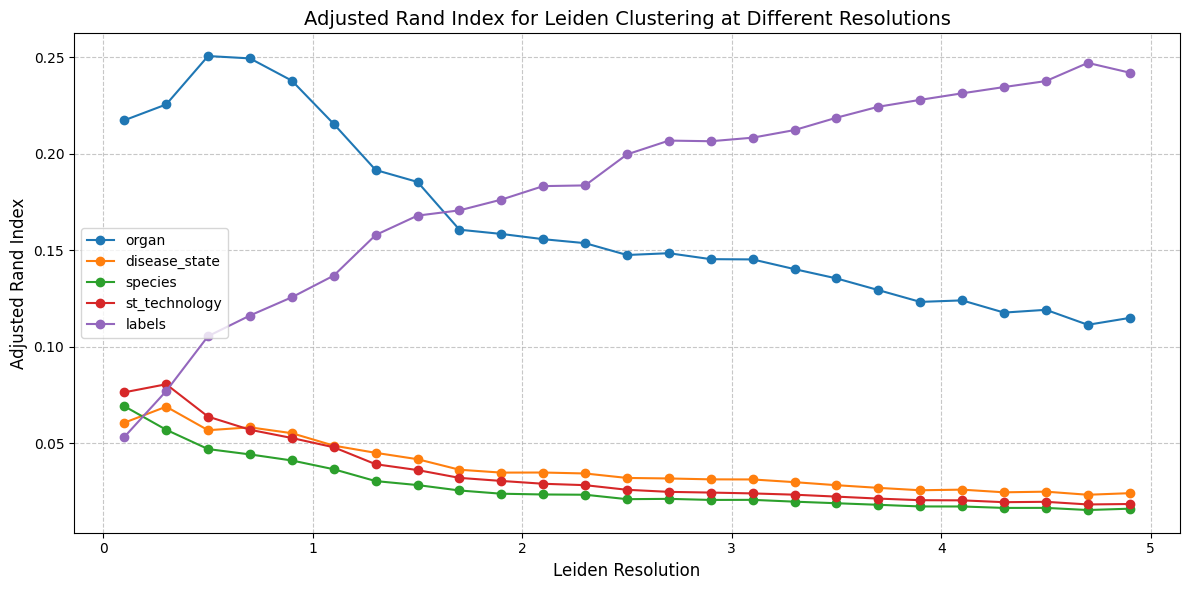

In [33]:
# Run for different resolutions of Leiden clustering with step of 0.2 and store clustering results. Then calculate ARI for each resolution.
columns_to_use = ['organ', 'disease_state', 'species', 'st_technology', 'labels']

resolutions = np.arange(0.1, 5.1, 0.2)
resolutions = np.round(resolutions, 1)  # Ensure consistent decimal precision

ari_results = {col: [] for col in columns_to_use}

# Use tqdm to show progress with a descriptive message
for resolution in tqdm(resolutions, desc="Running Leiden clustering at different resolutions"):
    sc.tl.leiden(adata, resolution=resolution, key_added=f'leiden_{resolution:.1f}')
    leiden_labels = adata.obs[f'leiden_{resolution:.1f}'].astype(int).values
    
    for col in columns_to_use:
        if col in adata.obs.columns and adata.obs[col].notna().sum() > 0:
            col_labels = adata.obs[col].astype('category').cat.codes
            mask = col_labels != -1
            if mask.sum() > 0:
                ari = adjusted_rand_score(col_labels[mask], leiden_labels[mask])
                ari_results[col].append(ari)
            else:
                ari_results[col].append(np.nan)
        else:
            ari_results[col].append(np.nan)

# Plot ARI results
plt.figure(figsize=(12, 6))
for col in columns_to_use:
    plt.plot(resolutions, ari_results[col], marker='o', label=col)

plt.xlabel("Leiden Resolution", fontsize=12)
plt.ylabel("Adjusted Rand Index", fontsize=12)
plt.title("Adjusted Rand Index for Leiden Clustering at Different Resolutions", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


Running Leiden clustering at different resolutions:   0%|          | 0/150 [00:00<?, ?it/s]

running Leiden clustering


    finished: found 33 clusters and added
    'leiden_0.1', the cluster labels (adata.obs, categorical) (0:00:11)


Running Leiden clustering at different resolutions:   1%|          | 1/150 [00:11<27:42, 11.16s/it]

running Leiden clustering
    finished: found 61 clusters and added
    'leiden_0.3', the cluster labels (adata.obs, categorical) (0:00:14)


Running Leiden clustering at different resolutions:   1%|▏         | 2/150 [00:25<32:50, 13.31s/it]

running Leiden clustering
    finished: found 72 clusters and added
    'leiden_0.5', the cluster labels (adata.obs, categorical) (0:00:17)


Running Leiden clustering at different resolutions:   2%|▏         | 3/150 [00:43<36:55, 15.07s/it]

running Leiden clustering
    finished: found 87 clusters and added
    'leiden_0.7', the cluster labels (adata.obs, categorical) (0:00:12)


Running Leiden clustering at different resolutions:   3%|▎         | 4/150 [00:55<33:57, 13.96s/it]

running Leiden clustering
    finished: found 93 clusters and added
    'leiden_0.9', the cluster labels (adata.obs, categorical) (0:00:10)


Running Leiden clustering at different resolutions:   3%|▎         | 5/150 [01:06<31:08, 12.89s/it]

running Leiden clustering
    finished: found 101 clusters and added
    'leiden_1.1', the cluster labels (adata.obs, categorical) (0:00:09)


Running Leiden clustering at different resolutions:   4%|▍         | 6/150 [01:16<28:24, 11.83s/it]

running Leiden clustering
    finished: found 111 clusters and added
    'leiden_1.3', the cluster labels (adata.obs, categorical) (0:00:12)


Running Leiden clustering at different resolutions:   5%|▍         | 7/150 [01:28<28:32, 11.98s/it]

running Leiden clustering
    finished: found 120 clusters and added
    'leiden_1.5', the cluster labels (adata.obs, categorical) (0:00:13)


Running Leiden clustering at different resolutions:   5%|▌         | 8/150 [01:41<29:27, 12.44s/it]

running Leiden clustering
    finished: found 127 clusters and added
    'leiden_1.7', the cluster labels (adata.obs, categorical) (0:00:12)


Running Leiden clustering at different resolutions:   6%|▌         | 9/150 [01:54<29:06, 12.39s/it]

running Leiden clustering
    finished: found 132 clusters and added
    'leiden_1.9', the cluster labels (adata.obs, categorical) (0:00:23)


Running Leiden clustering at different resolutions:   7%|▋         | 10/150 [02:17<36:44, 15.74s/it]

running Leiden clustering
    finished: found 141 clusters and added
    'leiden_2.1', the cluster labels (adata.obs, categorical) (0:00:09)


Running Leiden clustering at different resolutions:   7%|▋         | 11/150 [02:27<32:15, 13.92s/it]

running Leiden clustering
    finished: found 148 clusters and added
    'leiden_2.3', the cluster labels (adata.obs, categorical) (0:00:12)


Running Leiden clustering at different resolutions:   8%|▊         | 12/150 [02:39<30:50, 13.41s/it]

running Leiden clustering
    finished: found 159 clusters and added
    'leiden_2.5', the cluster labels (adata.obs, categorical) (0:00:14)


Running Leiden clustering at different resolutions:   9%|▊         | 13/150 [02:54<31:31, 13.81s/it]

running Leiden clustering
    finished: found 162 clusters and added
    'leiden_2.7', the cluster labels (adata.obs, categorical) (0:00:17)


Running Leiden clustering at different resolutions:   9%|▉         | 14/150 [03:11<33:36, 14.82s/it]

running Leiden clustering
    finished: found 166 clusters and added
    'leiden_2.9', the cluster labels (adata.obs, categorical) (0:00:14)


Running Leiden clustering at different resolutions:  10%|█         | 15/150 [03:26<33:17, 14.80s/it]

running Leiden clustering
    finished: found 169 clusters and added
    'leiden_3.1', the cluster labels (adata.obs, categorical) (0:00:14)


Running Leiden clustering at different resolutions:  11%|█         | 16/150 [03:40<32:57, 14.76s/it]

running Leiden clustering
    finished: found 175 clusters and added
    'leiden_3.3', the cluster labels (adata.obs, categorical) (0:00:13)


Running Leiden clustering at different resolutions:  11%|█▏        | 17/150 [03:54<31:47, 14.34s/it]

running Leiden clustering
    finished: found 179 clusters and added
    'leiden_3.5', the cluster labels (adata.obs, categorical) (0:00:14)


Running Leiden clustering at different resolutions:  12%|█▏        | 18/150 [04:08<31:47, 14.45s/it]

running Leiden clustering
    finished: found 185 clusters and added
    'leiden_3.7', the cluster labels (adata.obs, categorical) (0:00:10)


Running Leiden clustering at different resolutions:  13%|█▎        | 19/150 [04:19<29:16, 13.41s/it]

running Leiden clustering
    finished: found 188 clusters and added
    'leiden_3.9', the cluster labels (adata.obs, categorical) (0:00:15)


Running Leiden clustering at different resolutions:  13%|█▎        | 20/150 [04:35<30:36, 14.13s/it]

running Leiden clustering
    finished: found 189 clusters and added
    'leiden_4.1', the cluster labels (adata.obs, categorical) (0:00:17)


Running Leiden clustering at different resolutions:  14%|█▍        | 21/150 [04:52<32:19, 15.04s/it]

running Leiden clustering
    finished: found 196 clusters and added
    'leiden_4.3', the cluster labels (adata.obs, categorical) (0:00:19)


Running Leiden clustering at different resolutions:  15%|█▍        | 22/150 [05:12<34:52, 16.35s/it]

running Leiden clustering
    finished: found 199 clusters and added
    'leiden_4.5', the cluster labels (adata.obs, categorical) (0:00:10)


Running Leiden clustering at different resolutions:  15%|█▌        | 23/150 [05:23<31:09, 14.72s/it]

running Leiden clustering
    finished: found 203 clusters and added
    'leiden_4.7', the cluster labels (adata.obs, categorical) (0:00:19)


Running Leiden clustering at different resolutions:  16%|█▌        | 24/150 [05:42<33:50, 16.11s/it]

running Leiden clustering
    finished: found 205 clusters and added
    'leiden_4.9', the cluster labels (adata.obs, categorical) (0:00:14)


Running Leiden clustering at different resolutions:  17%|█▋        | 25/150 [05:56<32:33, 15.63s/it]

running Leiden clustering
    finished: found 209 clusters and added
    'leiden_5.1', the cluster labels (adata.obs, categorical) (0:00:14)


Running Leiden clustering at different resolutions:  17%|█▋        | 26/150 [06:11<31:36, 15.30s/it]

running Leiden clustering
    finished: found 211 clusters and added
    'leiden_5.3', the cluster labels (adata.obs, categorical) (0:00:13)


Running Leiden clustering at different resolutions:  18%|█▊        | 27/150 [06:24<30:09, 14.71s/it]

running Leiden clustering
    finished: found 209 clusters and added
    'leiden_5.5', the cluster labels (adata.obs, categorical) (0:00:10)


Running Leiden clustering at different resolutions:  19%|█▊        | 28/150 [06:35<27:37, 13.59s/it]

running Leiden clustering
    finished: found 214 clusters and added
    'leiden_5.7', the cluster labels (adata.obs, categorical) (0:00:10)


Running Leiden clustering at different resolutions:  19%|█▉        | 29/150 [06:46<25:47, 12.79s/it]

running Leiden clustering
    finished: found 220 clusters and added
    'leiden_5.9', the cluster labels (adata.obs, categorical) (0:00:13)


Running Leiden clustering at different resolutions:  20%|██        | 30/150 [07:00<25:54, 12.95s/it]

running Leiden clustering
    finished: found 221 clusters and added
    'leiden_6.1', the cluster labels (adata.obs, categorical) (0:00:15)


Running Leiden clustering at different resolutions:  21%|██        | 31/150 [07:15<27:25, 13.83s/it]

running Leiden clustering
    finished: found 226 clusters and added
    'leiden_6.3', the cluster labels (adata.obs, categorical) (0:00:19)


Running Leiden clustering at different resolutions:  21%|██▏       | 32/150 [07:35<30:26, 15.48s/it]

running Leiden clustering
    finished: found 228 clusters and added
    'leiden_6.5', the cluster labels (adata.obs, categorical) (0:00:15)


Running Leiden clustering at different resolutions:  22%|██▏       | 33/150 [07:51<30:21, 15.57s/it]

running Leiden clustering
    finished: found 232 clusters and added
    'leiden_6.7', the cluster labels (adata.obs, categorical) (0:00:21)


Running Leiden clustering at different resolutions:  23%|██▎       | 34/150 [08:12<33:43, 17.45s/it]

running Leiden clustering
    finished: found 233 clusters and added
    'leiden_6.9', the cluster labels (adata.obs, categorical) (0:00:16)


Running Leiden clustering at different resolutions:  23%|██▎       | 35/150 [08:29<33:10, 17.31s/it]

running Leiden clustering
    finished: found 242 clusters and added
    'leiden_7.1', the cluster labels (adata.obs, categorical) (0:00:21)


Running Leiden clustering at different resolutions:  24%|██▍       | 36/150 [08:51<35:27, 18.67s/it]

running Leiden clustering
    finished: found 238 clusters and added
    'leiden_7.3', the cluster labels (adata.obs, categorical) (0:00:12)


Running Leiden clustering at different resolutions:  25%|██▍       | 37/150 [09:03<31:25, 16.69s/it]

running Leiden clustering
    finished: found 240 clusters and added
    'leiden_7.5', the cluster labels (adata.obs, categorical) (0:00:20)


Running Leiden clustering at different resolutions:  25%|██▌       | 38/150 [09:24<33:20, 17.86s/it]

running Leiden clustering
    finished: found 243 clusters and added
    'leiden_7.7', the cluster labels (adata.obs, categorical) (0:00:14)


Running Leiden clustering at different resolutions:  26%|██▌       | 39/150 [09:38<31:11, 16.86s/it]

running Leiden clustering
    finished: found 242 clusters and added
    'leiden_7.9', the cluster labels (adata.obs, categorical) (0:00:26)


Running Leiden clustering at different resolutions:  27%|██▋       | 40/150 [10:05<36:16, 19.79s/it]

running Leiden clustering
    finished: found 243 clusters and added
    'leiden_8.1', the cluster labels (adata.obs, categorical) (0:00:21)


Running Leiden clustering at different resolutions:  27%|██▋       | 41/150 [10:27<37:03, 20.40s/it]

running Leiden clustering
    finished: found 245 clusters and added
    'leiden_8.3', the cluster labels (adata.obs, categorical) (0:00:21)


Running Leiden clustering at different resolutions:  28%|██▊       | 42/150 [10:49<37:26, 20.80s/it]

running Leiden clustering
    finished: found 249 clusters and added
    'leiden_8.5', the cluster labels (adata.obs, categorical) (0:00:18)


Running Leiden clustering at different resolutions:  29%|██▊       | 43/150 [11:07<35:39, 19.99s/it]

running Leiden clustering
    finished: found 249 clusters and added
    'leiden_8.7', the cluster labels (adata.obs, categorical) (0:00:27)


Running Leiden clustering at different resolutions:  29%|██▉       | 44/150 [11:34<39:26, 22.33s/it]

running Leiden clustering
    finished: found 253 clusters and added
    'leiden_8.9', the cluster labels (adata.obs, categorical) (0:00:16)


Running Leiden clustering at different resolutions:  30%|███       | 45/150 [11:51<36:13, 20.70s/it]

running Leiden clustering
    finished: found 249 clusters and added
    'leiden_9.1', the cluster labels (adata.obs, categorical) (0:00:16)


Running Leiden clustering at different resolutions:  31%|███       | 46/150 [12:08<33:55, 19.57s/it]

running Leiden clustering
    finished: found 259 clusters and added
    'leiden_9.3', the cluster labels (adata.obs, categorical) (0:00:27)


Running Leiden clustering at different resolutions:  31%|███▏      | 47/150 [12:36<37:50, 22.04s/it]

running Leiden clustering
    finished: found 257 clusters and added
    'leiden_9.5', the cluster labels (adata.obs, categorical) (0:00:18)


Running Leiden clustering at different resolutions:  32%|███▏      | 48/150 [12:54<35:27, 20.86s/it]

running Leiden clustering
    finished: found 259 clusters and added
    'leiden_9.7', the cluster labels (adata.obs, categorical) (0:00:13)


Running Leiden clustering at different resolutions:  33%|███▎      | 49/150 [13:08<31:20, 18.62s/it]

running Leiden clustering
    finished: found 264 clusters and added
    'leiden_9.9', the cluster labels (adata.obs, categorical) (0:00:10)


Running Leiden clustering at different resolutions:  33%|███▎      | 50/150 [13:18<27:10, 16.30s/it]

running Leiden clustering
    finished: found 268 clusters and added
    'leiden_10.1', the cluster labels (adata.obs, categorical) (0:00:13)


Running Leiden clustering at different resolutions:  34%|███▍      | 51/150 [13:32<25:26, 15.42s/it]

running Leiden clustering
    finished: found 268 clusters and added
    'leiden_10.3', the cluster labels (adata.obs, categorical) (0:00:24)


Running Leiden clustering at different resolutions:  35%|███▍      | 52/150 [13:56<29:29, 18.06s/it]

running Leiden clustering
    finished: found 275 clusters and added
    'leiden_10.5', the cluster labels (adata.obs, categorical) (0:00:16)


Running Leiden clustering at different resolutions:  35%|███▌      | 53/150 [14:13<28:41, 17.75s/it]

running Leiden clustering
    finished: found 275 clusters and added
    'leiden_10.7', the cluster labels (adata.obs, categorical) (0:00:25)


Running Leiden clustering at different resolutions:  36%|███▌      | 54/150 [14:38<32:00, 20.01s/it]

running Leiden clustering
    finished: found 273 clusters and added
    'leiden_10.9', the cluster labels (adata.obs, categorical) (0:00:18)


Running Leiden clustering at different resolutions:  37%|███▋      | 55/150 [14:56<30:47, 19.45s/it]

running Leiden clustering
    finished: found 281 clusters and added
    'leiden_11.1', the cluster labels (adata.obs, categorical) (0:00:19)


Running Leiden clustering at different resolutions:  37%|███▋      | 56/150 [15:16<30:23, 19.40s/it]

running Leiden clustering
    finished: found 284 clusters and added
    'leiden_11.3', the cluster labels (adata.obs, categorical) (0:00:16)


Running Leiden clustering at different resolutions:  38%|███▊      | 57/150 [15:33<28:55, 18.66s/it]

running Leiden clustering
    finished: found 287 clusters and added
    'leiden_11.5', the cluster labels (adata.obs, categorical) (0:00:20)


Running Leiden clustering at different resolutions:  39%|███▊      | 58/150 [15:53<29:30, 19.25s/it]

running Leiden clustering
    finished: found 290 clusters and added
    'leiden_11.7', the cluster labels (adata.obs, categorical) (0:00:21)


Running Leiden clustering at different resolutions:  39%|███▉      | 59/150 [16:15<30:27, 20.08s/it]

running Leiden clustering
    finished: found 292 clusters and added
    'leiden_11.9', the cluster labels (adata.obs, categorical) (0:00:18)


Running Leiden clustering at different resolutions:  40%|████      | 60/150 [16:33<29:13, 19.48s/it]

running Leiden clustering
    finished: found 291 clusters and added
    'leiden_12.1', the cluster labels (adata.obs, categorical) (0:00:22)


Running Leiden clustering at different resolutions:  41%|████      | 61/150 [16:56<30:24, 20.50s/it]

running Leiden clustering
    finished: found 299 clusters and added
    'leiden_12.3', the cluster labels (adata.obs, categorical) (0:00:25)


Running Leiden clustering at different resolutions:  41%|████▏     | 62/150 [17:22<32:14, 21.99s/it]

running Leiden clustering
    finished: found 298 clusters and added
    'leiden_12.5', the cluster labels (adata.obs, categorical) (0:00:13)


Running Leiden clustering at different resolutions:  42%|████▏     | 63/150 [17:35<28:05, 19.37s/it]

running Leiden clustering
    finished: found 303 clusters and added
    'leiden_12.7', the cluster labels (adata.obs, categorical) (0:00:16)


Running Leiden clustering at different resolutions:  43%|████▎     | 64/150 [17:52<26:43, 18.64s/it]

running Leiden clustering
    finished: found 302 clusters and added
    'leiden_12.9', the cluster labels (adata.obs, categorical) (0:00:21)


Running Leiden clustering at different resolutions:  43%|████▎     | 65/150 [18:14<27:46, 19.60s/it]

running Leiden clustering
    finished: found 307 clusters and added
    'leiden_13.1', the cluster labels (adata.obs, categorical) (0:00:19)


Running Leiden clustering at different resolutions:  44%|████▍     | 66/150 [18:33<27:21, 19.54s/it]

running Leiden clustering
    finished: found 310 clusters and added
    'leiden_13.3', the cluster labels (adata.obs, categorical) (0:00:18)


Running Leiden clustering at different resolutions:  45%|████▍     | 67/150 [18:51<26:27, 19.13s/it]

running Leiden clustering
    finished: found 314 clusters and added
    'leiden_13.5', the cluster labels (adata.obs, categorical) (0:00:16)


Running Leiden clustering at different resolutions:  45%|████▌     | 68/150 [19:08<25:14, 18.47s/it]

running Leiden clustering
    finished: found 311 clusters and added
    'leiden_13.7', the cluster labels (adata.obs, categorical) (0:00:15)


Running Leiden clustering at different resolutions:  46%|████▌     | 69/150 [19:24<23:48, 17.63s/it]

running Leiden clustering
    finished: found 318 clusters and added
    'leiden_13.9', the cluster labels (adata.obs, categorical) (0:00:30)


Running Leiden clustering at different resolutions:  47%|████▋     | 70/150 [19:54<28:33, 21.41s/it]

running Leiden clustering
    finished: found 315 clusters and added
    'leiden_14.1', the cluster labels (adata.obs, categorical) (0:00:15)


Running Leiden clustering at different resolutions:  47%|████▋     | 71/150 [20:10<25:55, 19.69s/it]

running Leiden clustering
    finished: found 319 clusters and added
    'leiden_14.3', the cluster labels (adata.obs, categorical) (0:00:20)


Running Leiden clustering at different resolutions:  48%|████▊     | 72/150 [20:30<25:54, 19.92s/it]

running Leiden clustering
    finished: found 326 clusters and added
    'leiden_14.5', the cluster labels (adata.obs, categorical) (0:00:25)


Running Leiden clustering at different resolutions:  49%|████▊     | 73/150 [20:56<27:40, 21.56s/it]

running Leiden clustering
    finished: found 327 clusters and added
    'leiden_14.7', the cluster labels (adata.obs, categorical) (0:00:26)


Running Leiden clustering at different resolutions:  49%|████▉     | 74/150 [21:22<29:14, 23.08s/it]

running Leiden clustering
    finished: found 329 clusters and added
    'leiden_14.9', the cluster labels (adata.obs, categorical) (0:00:21)


Running Leiden clustering at different resolutions:  50%|█████     | 75/150 [21:44<28:21, 22.69s/it]

running Leiden clustering
    finished: found 332 clusters and added
    'leiden_15.1', the cluster labels (adata.obs, categorical) (0:00:28)


Running Leiden clustering at different resolutions:  51%|█████     | 76/150 [22:13<30:17, 24.56s/it]

running Leiden clustering
    finished: found 330 clusters and added
    'leiden_15.3', the cluster labels (adata.obs, categorical) (0:00:14)


Running Leiden clustering at different resolutions:  51%|█████▏    | 77/150 [22:28<26:12, 21.54s/it]

running Leiden clustering
    finished: found 333 clusters and added
    'leiden_15.5', the cluster labels (adata.obs, categorical) (0:00:28)


Running Leiden clustering at different resolutions:  52%|█████▏    | 78/150 [22:57<28:31, 23.77s/it]

running Leiden clustering
    finished: found 334 clusters and added
    'leiden_15.7', the cluster labels (adata.obs, categorical) (0:00:33)


Running Leiden clustering at different resolutions:  53%|█████▎    | 79/150 [23:30<31:40, 26.77s/it]

running Leiden clustering
    finished: found 336 clusters and added
    'leiden_15.9', the cluster labels (adata.obs, categorical) (0:00:18)


Running Leiden clustering at different resolutions:  53%|█████▎    | 80/150 [23:48<28:11, 24.17s/it]

running Leiden clustering
    finished: found 337 clusters and added
    'leiden_16.1', the cluster labels (adata.obs, categorical) (0:00:16)


Running Leiden clustering at different resolutions:  54%|█████▍    | 81/150 [24:05<25:17, 21.99s/it]

running Leiden clustering
    finished: found 337 clusters and added
    'leiden_16.3', the cluster labels (adata.obs, categorical) (0:00:16)


Running Leiden clustering at different resolutions:  55%|█████▍    | 82/150 [24:22<23:11, 20.46s/it]

running Leiden clustering
    finished: found 344 clusters and added
    'leiden_16.5', the cluster labels (adata.obs, categorical) (0:00:25)


Running Leiden clustering at different resolutions:  55%|█████▌    | 83/150 [24:48<24:30, 21.94s/it]

running Leiden clustering
    finished: found 340 clusters and added
    'leiden_16.7', the cluster labels (adata.obs, categorical) (0:00:13)


Running Leiden clustering at different resolutions:  56%|█████▌    | 84/150 [25:01<21:16, 19.34s/it]

running Leiden clustering
    finished: found 345 clusters and added
    'leiden_16.9', the cluster labels (adata.obs, categorical) (0:00:24)


Running Leiden clustering at different resolutions:  57%|█████▋    | 85/150 [25:25<22:30, 20.78s/it]

running Leiden clustering
    finished: found 350 clusters and added
    'leiden_17.1', the cluster labels (adata.obs, categorical) (0:00:16)


Running Leiden clustering at different resolutions:  57%|█████▋    | 86/150 [25:42<20:55, 19.61s/it]

running Leiden clustering
    finished: found 354 clusters and added
    'leiden_17.3', the cluster labels (adata.obs, categorical) (0:00:18)


Running Leiden clustering at different resolutions:  58%|█████▊    | 87/150 [26:00<20:08, 19.18s/it]

running Leiden clustering
    finished: found 351 clusters and added
    'leiden_17.5', the cluster labels (adata.obs, categorical) (0:00:18)


Running Leiden clustering at different resolutions:  59%|█████▊    | 88/150 [26:18<19:28, 18.85s/it]

running Leiden clustering
    finished: found 352 clusters and added
    'leiden_17.7', the cluster labels (adata.obs, categorical) (0:00:16)


Running Leiden clustering at different resolutions:  59%|█████▉    | 89/150 [26:35<18:33, 18.26s/it]

running Leiden clustering
    finished: found 354 clusters and added
    'leiden_17.9', the cluster labels (adata.obs, categorical) (0:00:22)


Running Leiden clustering at different resolutions:  60%|██████    | 90/150 [26:58<19:40, 19.68s/it]

running Leiden clustering
    finished: found 356 clusters and added
    'leiden_18.1', the cluster labels (adata.obs, categorical) (0:00:19)


Running Leiden clustering at different resolutions:  61%|██████    | 91/150 [27:17<19:15, 19.58s/it]

running Leiden clustering
    finished: found 364 clusters and added
    'leiden_18.3', the cluster labels (adata.obs, categorical) (0:00:15)


Running Leiden clustering at different resolutions:  61%|██████▏   | 92/150 [27:33<17:47, 18.40s/it]

running Leiden clustering
    finished: found 362 clusters and added
    'leiden_18.5', the cluster labels (adata.obs, categorical) (0:00:15)


Running Leiden clustering at different resolutions:  62%|██████▏   | 93/150 [27:49<16:42, 17.58s/it]

running Leiden clustering
    finished: found 361 clusters and added
    'leiden_18.7', the cluster labels (adata.obs, categorical) (0:00:16)


Running Leiden clustering at different resolutions:  63%|██████▎   | 94/150 [28:06<16:13, 17.39s/it]

running Leiden clustering
    finished: found 365 clusters and added
    'leiden_18.9', the cluster labels (adata.obs, categorical) (0:00:25)


Running Leiden clustering at different resolutions:  63%|██████▎   | 95/150 [28:31<18:08, 19.79s/it]

running Leiden clustering
    finished: found 371 clusters and added
    'leiden_19.1', the cluster labels (adata.obs, categorical) (0:00:21)


Running Leiden clustering at different resolutions:  64%|██████▍   | 96/150 [28:53<18:19, 20.37s/it]

running Leiden clustering
    finished: found 370 clusters and added
    'leiden_19.3', the cluster labels (adata.obs, categorical) (0:00:21)


Running Leiden clustering at different resolutions:  65%|██████▍   | 97/150 [29:15<18:21, 20.78s/it]

running Leiden clustering
    finished: found 371 clusters and added
    'leiden_19.5', the cluster labels (adata.obs, categorical) (0:00:18)


Running Leiden clustering at different resolutions:  65%|██████▌   | 98/150 [29:33<17:18, 19.98s/it]

running Leiden clustering
    finished: found 373 clusters and added
    'leiden_19.7', the cluster labels (adata.obs, categorical) (0:00:27)


Running Leiden clustering at different resolutions:  66%|██████▌   | 99/150 [30:00<18:59, 22.34s/it]

running Leiden clustering
    finished: found 377 clusters and added
    'leiden_19.9', the cluster labels (adata.obs, categorical) (0:00:15)


Running Leiden clustering at different resolutions:  67%|██████▋   | 100/150 [30:16<16:57, 20.35s/it]

running Leiden clustering
    finished: found 385 clusters and added
    'leiden_20.1', the cluster labels (adata.obs, categorical) (0:00:31)


Running Leiden clustering at different resolutions:  67%|██████▋   | 101/150 [30:48<19:18, 23.65s/it]

running Leiden clustering
    finished: found 384 clusters and added
    'leiden_20.3', the cluster labels (adata.obs, categorical) (0:00:24)


Running Leiden clustering at different resolutions:  68%|██████▊   | 102/150 [31:12<19:02, 23.81s/it]

running Leiden clustering
    finished: found 384 clusters and added
    'leiden_20.5', the cluster labels (adata.obs, categorical) (0:00:14)


Running Leiden clustering at different resolutions:  69%|██████▊   | 103/150 [31:26<16:27, 21.02s/it]

running Leiden clustering
    finished: found 387 clusters and added
    'leiden_20.7', the cluster labels (adata.obs, categorical) (0:00:28)


Running Leiden clustering at different resolutions:  69%|██████▉   | 104/150 [31:55<17:56, 23.41s/it]

running Leiden clustering
    finished: found 389 clusters and added
    'leiden_20.9', the cluster labels (adata.obs, categorical) (0:00:28)


Running Leiden clustering at different resolutions:  70%|███████   | 105/150 [32:24<18:48, 25.08s/it]

running Leiden clustering
    finished: found 394 clusters and added
    'leiden_21.1', the cluster labels (adata.obs, categorical) (0:00:19)


Running Leiden clustering at different resolutions:  71%|███████   | 106/150 [32:44<17:07, 23.36s/it]

running Leiden clustering
    finished: found 388 clusters and added
    'leiden_21.3', the cluster labels (adata.obs, categorical) (0:00:21)


Running Leiden clustering at different resolutions:  71%|███████▏  | 107/150 [33:05<16:23, 22.88s/it]

running Leiden clustering
    finished: found 394 clusters and added
    'leiden_21.5', the cluster labels (adata.obs, categorical) (0:00:25)


Running Leiden clustering at different resolutions:  72%|███████▏  | 108/150 [33:31<16:32, 23.63s/it]

running Leiden clustering
    finished: found 396 clusters and added
    'leiden_21.7', the cluster labels (adata.obs, categorical) (0:00:16)


Running Leiden clustering at different resolutions:  73%|███████▎  | 109/150 [33:48<14:46, 21.62s/it]

running Leiden clustering
    finished: found 397 clusters and added
    'leiden_21.9', the cluster labels (adata.obs, categorical) (0:00:26)


Running Leiden clustering at different resolutions:  73%|███████▎  | 110/150 [34:14<15:24, 23.10s/it]

running Leiden clustering
    finished: found 401 clusters and added
    'leiden_22.1', the cluster labels (adata.obs, categorical) (0:00:22)


Running Leiden clustering at different resolutions:  74%|███████▍  | 111/150 [34:37<14:59, 23.06s/it]

running Leiden clustering
    finished: found 400 clusters and added
    'leiden_22.3', the cluster labels (adata.obs, categorical) (0:00:21)


Running Leiden clustering at different resolutions:  75%|███████▍  | 112/150 [34:59<14:21, 22.66s/it]

running Leiden clustering
    finished: found 403 clusters and added
    'leiden_22.5', the cluster labels (adata.obs, categorical) (0:00:24)


Running Leiden clustering at different resolutions:  75%|███████▌  | 113/150 [35:23<14:15, 23.12s/it]

running Leiden clustering
    finished: found 405 clusters and added
    'leiden_22.7', the cluster labels (adata.obs, categorical) (0:00:18)


Running Leiden clustering at different resolutions:  76%|███████▌  | 114/150 [35:41<12:58, 21.62s/it]

running Leiden clustering
    finished: found 408 clusters and added
    'leiden_22.9', the cluster labels (adata.obs, categorical) (0:00:14)


Running Leiden clustering at different resolutions:  77%|███████▋  | 115/150 [35:56<11:21, 19.48s/it]

running Leiden clustering
    finished: found 411 clusters and added
    'leiden_23.1', the cluster labels (adata.obs, categorical) (0:00:21)


Running Leiden clustering at different resolutions:  77%|███████▋  | 116/150 [36:17<11:25, 20.16s/it]

running Leiden clustering
    finished: found 410 clusters and added
    'leiden_23.3', the cluster labels (adata.obs, categorical) (0:00:21)


Running Leiden clustering at different resolutions:  78%|███████▊  | 117/150 [36:39<11:21, 20.65s/it]

running Leiden clustering
    finished: found 411 clusters and added
    'leiden_23.5', the cluster labels (adata.obs, categorical) (0:00:21)


Running Leiden clustering at different resolutions:  79%|███████▊  | 118/150 [37:01<11:11, 20.98s/it]

running Leiden clustering
    finished: found 418 clusters and added
    'leiden_23.9', the cluster labels (adata.obs, categorical) (0:00:31)


Running Leiden clustering at different resolutions:  80%|████████  | 120/150 [37:58<12:33, 25.10s/it]

running Leiden clustering
    finished: found 416 clusters and added
    'leiden_24.1', the cluster labels (adata.obs, categorical) (0:00:27)


Running Leiden clustering at different resolutions:  81%|████████  | 121/150 [38:26<12:33, 25.98s/it]

running Leiden clustering
    finished: found 418 clusters and added
    'leiden_24.3', the cluster labels (adata.obs, categorical) (0:00:24)


Running Leiden clustering at different resolutions:  81%|████████▏ | 122/150 [38:50<11:52, 25.45s/it]

running Leiden clustering
    finished: found 417 clusters and added
    'leiden_24.5', the cluster labels (adata.obs, categorical) (0:00:29)


Running Leiden clustering at different resolutions:  82%|████████▏ | 123/150 [39:19<11:56, 26.55s/it]

running Leiden clustering
    finished: found 422 clusters and added
    'leiden_24.7', the cluster labels (adata.obs, categorical) (0:00:21)


Running Leiden clustering at different resolutions:  83%|████████▎ | 124/150 [39:41<10:53, 25.12s/it]

running Leiden clustering
    finished: found 425 clusters and added
    'leiden_24.9', the cluster labels (adata.obs, categorical) (0:00:16)


Running Leiden clustering at different resolutions:  83%|████████▎ | 125/150 [39:58<09:26, 22.67s/it]

running Leiden clustering
    finished: found 426 clusters and added
    'leiden_25.1', the cluster labels (adata.obs, categorical) (0:00:26)


Running Leiden clustering at different resolutions:  84%|████████▍ | 126/150 [40:25<09:32, 23.85s/it]

running Leiden clustering
    finished: found 426 clusters and added
    'leiden_25.3', the cluster labels (adata.obs, categorical) (0:00:24)


Running Leiden clustering at different resolutions:  85%|████████▍ | 127/150 [40:49<09:10, 23.96s/it]

running Leiden clustering
    finished: found 428 clusters and added
    'leiden_25.5', the cluster labels (adata.obs, categorical) (0:00:21)


Running Leiden clustering at different resolutions:  85%|████████▌ | 128/150 [41:11<08:32, 23.30s/it]

running Leiden clustering
    finished: found 429 clusters and added
    'leiden_25.7', the cluster labels (adata.obs, categorical) (0:00:39)


Running Leiden clustering at different resolutions:  86%|████████▌ | 129/150 [41:51<09:53, 28.28s/it]

running Leiden clustering
    finished: found 430 clusters and added
    'leiden_25.9', the cluster labels (adata.obs, categorical) (0:00:25)


Running Leiden clustering at different resolutions:  87%|████████▋ | 130/150 [42:16<09:08, 27.43s/it]

running Leiden clustering
    finished: found 438 clusters and added
    'leiden_26.1', the cluster labels (adata.obs, categorical) (0:00:28)


Running Leiden clustering at different resolutions:  87%|████████▋ | 131/150 [42:45<08:50, 27.92s/it]

running Leiden clustering
    finished: found 436 clusters and added
    'leiden_26.3', the cluster labels (adata.obs, categorical) (0:00:25)


Running Leiden clustering at different resolutions:  88%|████████▊ | 132/150 [43:10<08:09, 27.17s/it]

running Leiden clustering
    finished: found 438 clusters and added
    'leiden_26.5', the cluster labels (adata.obs, categorical) (0:00:21)


Running Leiden clustering at different resolutions:  89%|████████▊ | 133/150 [43:32<07:14, 25.55s/it]

running Leiden clustering
    finished: found 442 clusters and added
    'leiden_26.7', the cluster labels (adata.obs, categorical) (0:00:37)


Running Leiden clustering at different resolutions:  89%|████████▉ | 134/150 [44:10<07:46, 29.17s/it]

running Leiden clustering
    finished: found 441 clusters and added
    'leiden_26.9', the cluster labels (adata.obs, categorical) (0:00:30)


Running Leiden clustering at different resolutions:  90%|█████████ | 135/150 [44:40<07:22, 29.50s/it]

running Leiden clustering
    finished: found 443 clusters and added
    'leiden_27.1', the cluster labels (adata.obs, categorical) (0:00:19)


Running Leiden clustering at different resolutions:  91%|█████████ | 136/150 [44:59<06:10, 26.46s/it]

running Leiden clustering
    finished: found 449 clusters and added
    'leiden_27.3', the cluster labels (adata.obs, categorical) (0:00:22)


Running Leiden clustering at different resolutions:  91%|█████████▏| 137/150 [45:22<05:30, 25.42s/it]

running Leiden clustering
    finished: found 445 clusters and added
    'leiden_27.5', the cluster labels (adata.obs, categorical) (0:00:19)


Running Leiden clustering at different resolutions:  92%|█████████▏| 138/150 [45:42<04:43, 23.60s/it]

running Leiden clustering
    finished: found 449 clusters and added
    'leiden_27.7', the cluster labels (adata.obs, categorical) (0:00:27)


Running Leiden clustering at different resolutions:  93%|█████████▎| 139/150 [46:10<04:33, 24.88s/it]

running Leiden clustering
    finished: found 450 clusters and added
    'leiden_27.9', the cluster labels (adata.obs, categorical) (0:00:26)


Running Leiden clustering at different resolutions:  93%|█████████▎| 140/150 [46:36<04:14, 25.41s/it]

running Leiden clustering
    finished: found 451 clusters and added
    'leiden_28.1', the cluster labels (adata.obs, categorical) (0:00:37)


Running Leiden clustering at different resolutions:  94%|█████████▍| 141/150 [47:14<04:21, 29.05s/it]

running Leiden clustering
    finished: found 454 clusters and added
    'leiden_28.3', the cluster labels (adata.obs, categorical) (0:00:20)


Running Leiden clustering at different resolutions:  95%|█████████▍| 142/150 [47:34<03:32, 26.51s/it]

running Leiden clustering
    finished: found 450 clusters and added
    'leiden_28.5', the cluster labels (adata.obs, categorical) (0:00:16)


Running Leiden clustering at different resolutions:  95%|█████████▌| 143/150 [47:51<02:45, 23.63s/it]

running Leiden clustering
    finished: found 455 clusters and added
    'leiden_28.7', the cluster labels (adata.obs, categorical) (0:00:18)


Running Leiden clustering at different resolutions:  96%|█████████▌| 144/150 [48:10<02:11, 21.99s/it]

running Leiden clustering
    finished: found 454 clusters and added
    'leiden_28.9', the cluster labels (adata.obs, categorical) (0:00:25)


Running Leiden clustering at different resolutions:  97%|█████████▋| 145/150 [48:35<01:55, 23.02s/it]

running Leiden clustering
    finished: found 460 clusters and added
    'leiden_29.1', the cluster labels (adata.obs, categorical) (0:00:31)


Running Leiden clustering at different resolutions:  97%|█████████▋| 146/150 [49:06<01:42, 25.56s/it]

running Leiden clustering
    finished: found 460 clusters and added
    'leiden_29.3', the cluster labels (adata.obs, categorical) (0:00:32)


Running Leiden clustering at different resolutions:  98%|█████████▊| 147/150 [49:39<01:23, 27.72s/it]

running Leiden clustering
    finished: found 459 clusters and added
    'leiden_29.5', the cluster labels (adata.obs, categorical) (0:00:18)


Running Leiden clustering at different resolutions:  99%|█████████▊| 148/150 [49:57<00:49, 24.85s/it]

running Leiden clustering
    finished: found 460 clusters and added
    'leiden_29.7', the cluster labels (adata.obs, categorical) (0:00:32)


Running Leiden clustering at different resolutions:  99%|█████████▉| 149/150 [50:30<00:27, 27.21s/it]

running Leiden clustering
    finished: found 466 clusters and added
    'leiden_29.9', the cluster labels (adata.obs, categorical) (0:00:20)


Running Leiden clustering at different resolutions: 100%|██████████| 150/150 [50:51<00:00, 20.34s/it]


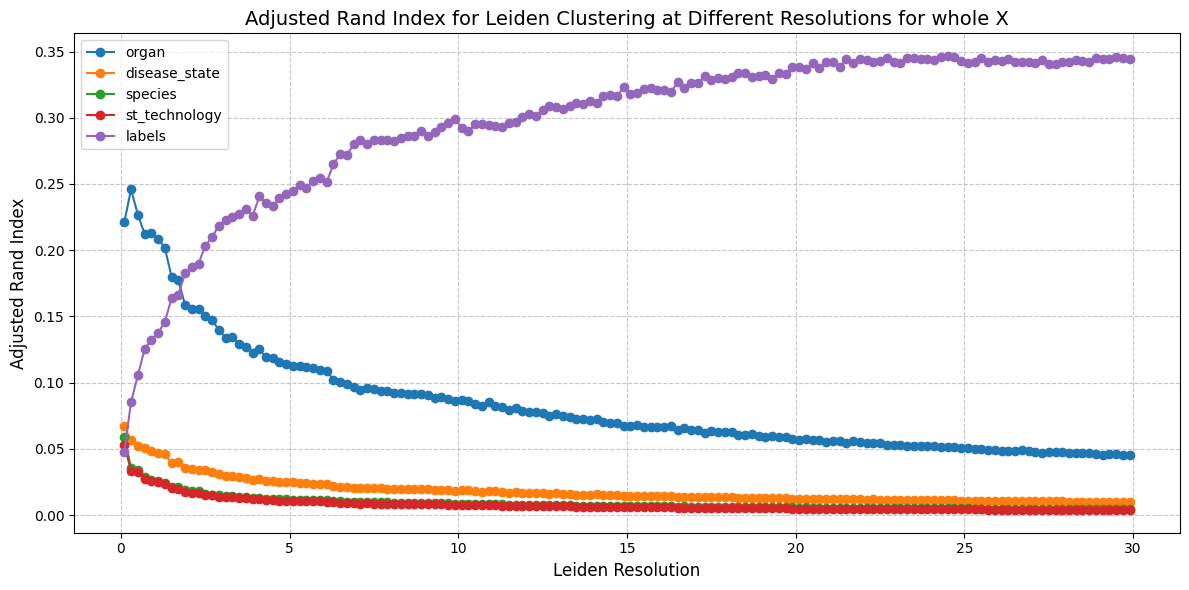

In [53]:
# Run for different resolutions of Leiden clustering with step of 0.2 and store clustering results. Then calculate ARI for each resolution.
columns_to_use = ['organ', 'disease_state', 'species', 'st_technology', 'labels']

resolutions = np.arange(0.1, 30, 0.2)
resolutions = np.round(resolutions, 1)  # Ensure consistent decimal precision

ari_results = {col: [] for col in columns_to_use}

# Use tqdm to show progress with a descriptive message
for resolution in tqdm(resolutions, desc="Running Leiden clustering at different resolutions"):
    sc.tl.leiden(adata, resolution=resolution, key_added=f'leiden_{resolution:.1f}')
    leiden_labels = adata.obs[f'leiden_{resolution:.1f}'].astype(int).values
    
    for col in columns_to_use:
        if col in adata.obs.columns and adata.obs[col].notna().sum() > 0:
            col_labels = adata.obs[col].astype('category').cat.codes
            mask = col_labels != -1
            if mask.sum() > 0:
                ari = adjusted_rand_score(col_labels[mask], leiden_labels[mask])
                ari_results[col].append(ari)
            else:
                ari_results[col].append(np.nan)
        else:
            ari_results[col].append(np.nan)

# Plot ARI results
plt.figure(figsize=(12, 6))
for col in columns_to_use:
    plt.plot(resolutions, ari_results[col], marker='o', label=col)

plt.xlabel("Leiden Resolution", fontsize=12)
plt.ylabel("Adjusted Rand Index", fontsize=12)
plt.title("Adjusted Rand Index for Leiden Clustering at Different Resolutions for whole X", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


# Use vae for comparison

In [55]:


# 您提供的 CustomDataset 类
class VaeDataset(Dataset):
    def __init__(self, data_dir):
        # 数据根目录
        self.data_dir = data_dir
        
        # 获取所有以 '_tiles' 结尾的文件夹
        self.tiles_folders = [f for f in os.listdir(data_dir) if f.endswith('_tiles')]
        
        # 从文件夹名称中提取样本编号作为标签
        self.labels = [f.split('_')[0] for f in self.tiles_folders]
        
        # 获取唯一的样本编号并创建整数映射
        self.unique_labels = list(set(self.labels))
        self.label_to_int = {label: i for i, label in enumerate(self.unique_labels)}
        
        # 收集所有图像路径和对应的标签
        self.image_paths = []
        self.image_labels = []
        for folder, label in zip(self.tiles_folders, self.labels):
            folder_path = os.path.join(data_dir, folder)
            # 假设图像文件格式为 .jpg 或 .png
            images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) 
                      if img.endswith('.jpg') or img.endswith('.png')]
            self.image_paths.extend(images)
            self.image_labels.extend([self.label_to_int[label]] * len(images))
        
        # 定义图像转换操作
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
    
    def __len__(self):
        # 返回数据集中的图像总数
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # 根据索引获取图像路径和标签
        img_path = self.image_paths[idx]
        label = self.image_labels[idx]
        
        # 加载图像并转换为 RGB 格式
        image = Image.open(img_path).convert('RGB')
        
        # 应用转换操作
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def get_label_name(self, label_int):
        # 根据整数标签返回原始样本编号
        return self.unique_labels[label_int]

# 加载数据集
data_dir = '/cwStorage/nodecw_group/jijh/hest_output'
vae_dataset = VaeDataset(data_dir)



In [56]:
from diffusers import AutoencoderTiny

def get_vae_model(sample_size=512, latent_channels=4, use_pretrained=False, sd_version='v2.1'):
    """
    获取 VAE 模型。
      - use_pretrained=True（默认）：加载预训练的 Tiny AutoEncoder 模型（保持参数为 FP32）。
          sd_version: 'v2.1'（默认）加载适用于 Stable Diffusion v2.1 的 Tiny AutoEncoder，
                      若设置为 'sdxl' 则加载适用于 SDXL 的版本。
      - use_pretrained=False：从头构造新的 Tiny AutoEncoder 模型（采用 TAESD 默认配置）。
    """
    if use_pretrained:
        if sd_version == 'v2.1':
            vae = AutoencoderTiny.from_pretrained("madebyollin/taesd", torch_dtype=torch.float32)
        elif sd_version == 'sdxl':
            vae = AutoencoderTiny.from_pretrained("madebyollin/taesdxl", torch_dtype=torch.float32)
        else:
            raise ValueError("sd_version 需为 'v2.1' 或 'sdxl'")
        print("Loaded pretrained Tiny AutoEncoder model.")
    else:
        # 从头构造 Tiny AutoEncoder 模型，参数取自 TAESD 默认设置
        vae = AutoencoderTiny(
            in_channels=3,
            out_channels=3,
            encoder_block_out_channels=(64, 64, 64, 64),
            decoder_block_out_channels=(64, 64, 64, 64),
            act_fn="relu",
            latent_channels=latent_channels,
            upsampling_scaling_factor=2,
            num_encoder_blocks=(1, 3, 3, 3),
            num_decoder_blocks=(3, 3, 3, 1),
            latent_magnitude=3.0,
            latent_shift=0.5,
            force_upcast=False,
            scaling_factor=1.0,
            shift_factor=0.0
        )
        print("Created new Tiny AutoEncoder model from scratch.")
    return vae


# 加载 VAE 模型，并加载预训练参数（路径请根据实际情况修改）
vae = get_vae_model(use_pretrained=False)
vae_state = torch.load('/cwStorage/nodecw_group/jijh/model_path/vae_epoch_10.pth', map_location='cpu')
vae.load_state_dict(vae_state)
vae.eval()  # 仅用于编码，不参与梯度更新
for param in vae.parameters():
    param.requires_grad = False

Created new Tiny AutoEncoder model from scratch.


In [57]:
# 随机抽取图像
num_samples = 45000  # 可调整的抽样数量
indices = random.sample(range(len(dataset)), num_samples)
subset = Subset(dataset, indices)
vae_dataloader = DataLoader(subset, batch_size=256, shuffle=False, num_workers=16)  # 使用多线程加速

In [60]:
# Test for first batch to see the vae.encode output
for images, batch_labels in vae_dataloader:
    images = images.to(device)
    encoded = vae.encode(images)
    # Access latent embeddings using the 'latents' attribute
    latent_embeddings = encoded.latents  
    break

In [65]:
latent_embeddings.shape

torch.Size([256, 4, 28, 28])

In [66]:
from tqdm import tqdm

# Move model to the specified device and set to evaluation mode
vae = vae.to(device)
vae.eval()

# Get embeddings and labels
vae_embeddings = []
labels = []

# Import tqdm for progress tracking

with torch.no_grad():
    # Use tqdm to show progress
    for images, batch_labels in tqdm(vae_dataloader, desc="Extracting embeddings"):
        # Move data to device
        images = images.to(device)
        
        # Model inference
        outputs = vae.encode(images).latents

        # Flatten latent embeddings: from [batch_size, latent_channels, H, W] to [batch_size, latent_dim]
        outputs = outputs.view(outputs.size(0), -1)

        
        # Move results back to CPU and convert to numpy
        vae_embeddings.append(outputs.cpu().numpy())
        labels.append(batch_labels.numpy())  # No need to move labels to device and back

# Concatenate results
vae_embeddings = np.concatenate(vae_embeddings, axis=0)  # [num_samples, embedding_dim]
labels = np.concatenate(labels, axis=0)          # [num_samples]

print(f"Generated vae_embeddings shape: {vae_embeddings.shape}")
print(f"Labels shape: {labels.shape}")

Extracting embeddings: 100%|██████████| 176/176 [00:50<00:00,  3.49it/s]


Generated vae_embeddings shape: (45000, 3136)
Labels shape: (45000,)


In [67]:
vae_adata = sc.AnnData(X=vae_embeddings, obs={"labels": labels})

In [69]:
vae_adata.obs['label_names'] = [dataset.get_label_name(label) for label in vae_adata.obs['labels']]
vae_adata.obs['label_categorical'] = vae_adata.obs['label_names'].astype('category')

import pandas as pd
hest_meta = pd.read_csv('/cwStorage/nodecw_group/jijh/hest_1k/HEST_v1_1_0.csv')
hest_meta
# Create a mapping from the metadata dataframe based on ID
# First, make sure we're working with string IDs in both dataframes
hest_meta['id'] = hest_meta['id'].astype(str)

# Create a dictionary to map sample ID to metadata
metadata_dict = {}
for idx, row in hest_meta.iterrows():
    sample_id = row['id']
    metadata_dict[sample_id] = row.to_dict()
    
# Add metadata columns to adata.obs
# Get list of unique sample IDs in our data
unique_samples = vae_adata.obs['label_names'].unique()

# Add metadata columns
meta_columns = [col for col in hest_meta.columns if col != 'id']

# Initialize with NaN values
for col in meta_columns:
    vae_adata.obs[col] = np.nan

# Fill in metadata where matches are found
for sample_id in unique_samples:
    if sample_id in metadata_dict:
        # For each matching sample, get all rows with that sample ID
        sample_rows = vae_adata.obs['label_names'] == sample_id
        # Add each metadata column
        for col in meta_columns:
            vae_adata.obs.loc[sample_rows, col] = metadata_dict[sample_id][col]

print(f"Added {len(meta_columns)} columns of metadata to AnnData object")
print(f"Found metadata for {sum(vae_adata.obs['label_names'].isin(metadata_dict.keys()))/len(vae_adata.obs)*100:.1f}% of samples")


/tmp/ipykernel_11375/2131481745.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Visium CytAssist Gene Expression Libraries of Post-Xenium Human Colon Cancer (FFPE)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  vae_adata.obs.loc[sample_rows, col] = metadata_dict[sample_id][col]
/tmp/ipykernel_11375/2131481745.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'TENX92.tif' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  vae_adata.obs.loc[sample_rows, col] = metadata_dict[sample_id][col]
/tmp/ipykernel_11375/2131481745.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Bowel' has dtype incompatible with float64, please explicitly cast to a compatibl

Added 27 columns of metadata to AnnData object
Found metadata for 100.0% of samples


In [70]:
vae_adata

AnnData object with n_obs × n_vars = 45000 × 3136
    obs: 'labels', 'label_names', 'label_categorical', 'dataset_title', 'image_filename', 'organ', 'disease_state', 'oncotree_code', 'species', 'patient', 'st_technology', 'data_publication_date', 'license', 'study_link', 'download_page_link1', 'inter_spot_dist', 'spot_diameter', 'spots_under_tissue', 'preservation_method', 'nb_genes', 'treatment_comment', 'pixel_size_um_embedded', 'pixel_size_um_estimated', 'magnification', 'fullres_px_width', 'fullres_px_height', 'tissue', 'disease_comment', 'subseries', 'hest_version_added'

computing PCA
    with n_comps=50
    finished (0:00:04)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:55)
running Leiden clustering
    finished: found 28 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:11)


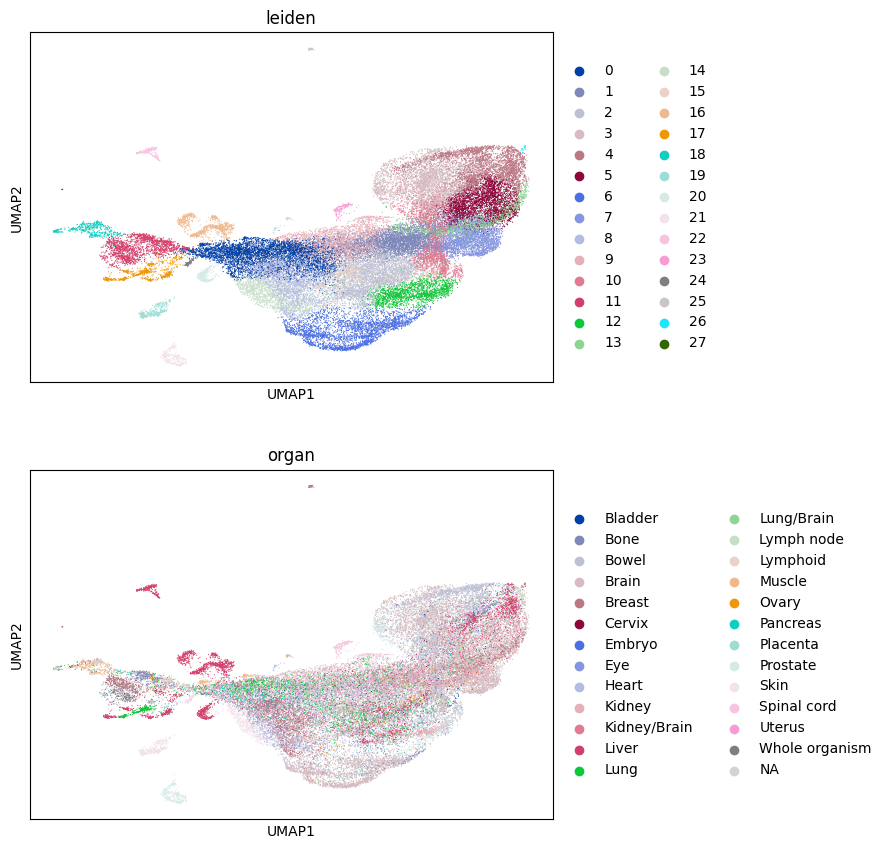

In [71]:
# PCA
sc.tl.pca(vae_adata, svd_solver='arpack', n_comps=50)

# 计算邻居
sc.pp.neighbors(vae_adata, n_neighbors=30, use_rep='X_pca')

# UMAP
sc.tl.umap(vae_adata)

# Leiden 聚类
sc.tl.leiden(vae_adata)

# 可视化 UMAP
sc.pl.umap(vae_adata, color=['leiden', 'organ'], ncols=1)



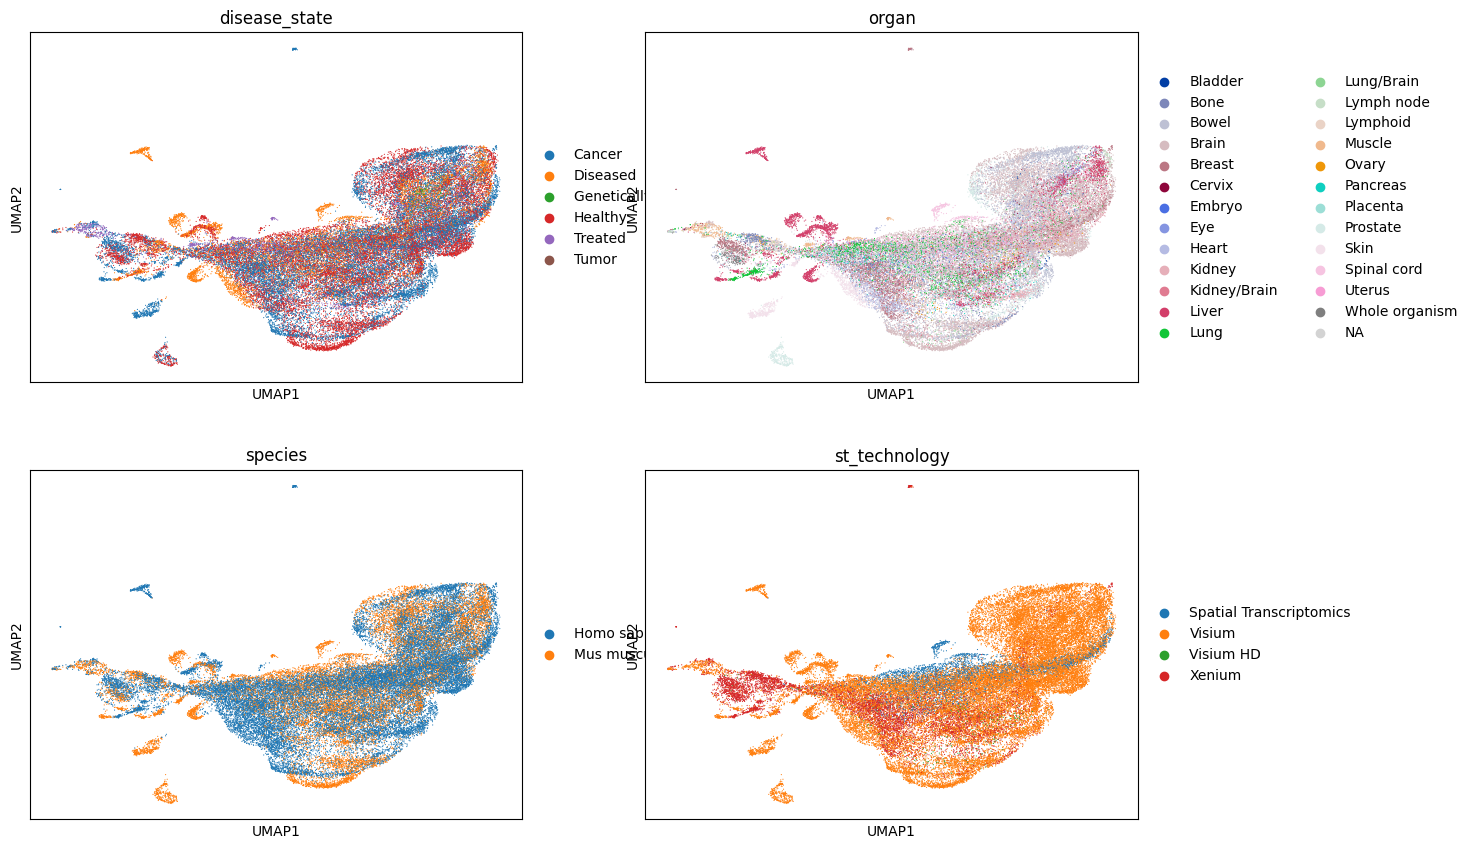

In [73]:
sc.pl.umap(vae_adata, color=['disease_state', 'organ', 'species', 'st_technology',], ncols=2)

In [75]:
# Calculate silhouette score (based on UMAP embeddings)
# Filter out NaN values in the organ column
mask = vae_adata.obs['organ'].notna()
if mask.sum() > 0:  # Make sure we have enough valid values
    silhouette_umap = silhouette_score(vae_adata.obsm['X_umap'][mask], vae_adata.obs['organ'][mask])
    print(f"Silhouette Score (UMAP): {silhouette_umap:.3f}")
else:
    print("Cannot calculate silhouette score: too many missing values in 'organ' column")

# Calculate adjusted rand index (Leiden clustering vs true labels)
# Handle categorical data properly
if mask.sum() > 0:
    leiden_labels = vae_adata.obs['leiden'].astype(int).values[mask]
    organ_labels = vae_adata.obs['organ'][mask].astype('category').cat.codes
    ari_leiden = adjusted_rand_score(organ_labels, leiden_labels)
    print(f"Adjusted Rand Index (Leiden vs Organ): {ari_leiden:.3f}")
else:
    print("Cannot calculate ARI: too many missing values in 'organ' column")

Silhouette Score (UMAP): -0.391
Adjusted Rand Index (Leiden vs Organ): 0.092


Running Leiden clustering at different resolutions:   0%|          | 0/25 [00:00<?, ?it/s]

running Leiden clustering
    finished: found 10 clusters and added
    'leiden_0.1', the cluster labels (adata.obs, categorical) (0:00:43)


Running Leiden clustering at different resolutions:   4%|▍         | 1/25 [00:43<17:16, 43.19s/it]

running Leiden clustering
    finished: found 14 clusters and added
    'leiden_0.3', the cluster labels (adata.obs, categorical) (0:00:38)


Running Leiden clustering at different resolutions:   8%|▊         | 2/25 [01:22<15:34, 40.64s/it]

running Leiden clustering
    finished: found 19 clusters and added
    'leiden_0.5', the cluster labels (adata.obs, categorical) (0:00:57)


Running Leiden clustering at different resolutions:  12%|█▏        | 3/25 [02:20<17:48, 48.55s/it]

running Leiden clustering
    finished: found 22 clusters and added
    'leiden_0.7', the cluster labels (adata.obs, categorical) (0:01:20)


Running Leiden clustering at different resolutions:  16%|█▌        | 4/25 [03:40<21:21, 61.04s/it]

running Leiden clustering
    finished: found 25 clusters and added
    'leiden_0.9', the cluster labels (adata.obs, categorical) (0:00:48)


Running Leiden clustering at different resolutions:  20%|██        | 5/25 [04:28<18:50, 56.51s/it]

running Leiden clustering
    finished: found 29 clusters and added
    'leiden_1.1', the cluster labels (adata.obs, categorical) (0:00:57)


Running Leiden clustering at different resolutions:  24%|██▍       | 6/25 [05:25<17:57, 56.72s/it]

running Leiden clustering
    finished: found 34 clusters and added
    'leiden_1.3', the cluster labels (adata.obs, categorical) (0:00:56)


Running Leiden clustering at different resolutions:  28%|██▊       | 7/25 [06:22<17:01, 56.73s/it]

running Leiden clustering
    finished: found 35 clusters and added
    'leiden_1.5', the cluster labels (adata.obs, categorical) (0:00:45)


Running Leiden clustering at different resolutions:  32%|███▏      | 8/25 [07:07<15:02, 53.11s/it]

running Leiden clustering
    finished: found 38 clusters and added
    'leiden_1.7', the cluster labels (adata.obs, categorical) (0:01:02)


Running Leiden clustering at different resolutions:  36%|███▌      | 9/25 [08:10<14:56, 56.04s/it]

running Leiden clustering
    finished: found 41 clusters and added
    'leiden_1.9', the cluster labels (adata.obs, categorical) (0:00:50)


Running Leiden clustering at different resolutions:  40%|████      | 10/25 [09:01<13:36, 54.44s/it]

running Leiden clustering
    finished: found 46 clusters and added
    'leiden_2.1', the cluster labels (adata.obs, categorical) (0:00:42)


Running Leiden clustering at different resolutions:  44%|████▍     | 11/25 [09:43<11:50, 50.78s/it]

running Leiden clustering
    finished: found 46 clusters and added
    'leiden_2.3', the cluster labels (adata.obs, categorical) (0:00:53)


Running Leiden clustering at different resolutions:  48%|████▊     | 12/25 [10:37<11:10, 51.57s/it]

running Leiden clustering
    finished: found 48 clusters and added
    'leiden_2.5', the cluster labels (adata.obs, categorical) (0:00:53)


Running Leiden clustering at different resolutions:  52%|█████▏    | 13/25 [11:30<10:25, 52.10s/it]

running Leiden clustering
    finished: found 49 clusters and added
    'leiden_2.7', the cluster labels (adata.obs, categorical) (0:01:04)


Running Leiden clustering at different resolutions:  56%|█████▌    | 14/25 [12:35<10:14, 55.89s/it]

running Leiden clustering
    finished: found 53 clusters and added
    'leiden_2.9', the cluster labels (adata.obs, categorical) (0:00:58)


Running Leiden clustering at different resolutions:  60%|██████    | 15/25 [13:33<09:27, 56.76s/it]

running Leiden clustering
    finished: found 55 clusters and added
    'leiden_3.1', the cluster labels (adata.obs, categorical) (0:00:42)


Running Leiden clustering at different resolutions:  64%|██████▍   | 16/25 [14:16<07:51, 52.44s/it]

running Leiden clustering
    finished: found 63 clusters and added
    'leiden_3.7', the cluster labels (adata.obs, categorical) (0:01:15)


Running Leiden clustering at different resolutions:  76%|███████▌  | 19/25 [17:23<06:00, 60.12s/it]

running Leiden clustering
    finished: found 64 clusters and added
    'leiden_3.9', the cluster labels (adata.obs, categorical) (0:01:12)


Running Leiden clustering at different resolutions:  80%|████████  | 20/25 [18:36<05:19, 63.89s/it]

running Leiden clustering
    finished: found 68 clusters and added
    'leiden_4.1', the cluster labels (adata.obs, categorical) (0:01:04)


Running Leiden clustering at different resolutions:  84%|████████▍ | 21/25 [19:40<04:16, 64.01s/it]

running Leiden clustering
    finished: found 70 clusters and added
    'leiden_4.3', the cluster labels (adata.obs, categorical) (0:01:17)


Running Leiden clustering at different resolutions:  88%|████████▊ | 22/25 [20:58<03:24, 68.21s/it]

running Leiden clustering
    finished: found 73 clusters and added
    'leiden_4.5', the cluster labels (adata.obs, categorical) (0:01:32)


Running Leiden clustering at different resolutions:  92%|█████████▏| 23/25 [22:31<02:30, 75.41s/it]

running Leiden clustering
    finished: found 76 clusters and added
    'leiden_4.7', the cluster labels (adata.obs, categorical) (0:01:23)


Running Leiden clustering at different resolutions:  96%|█████████▌| 24/25 [23:54<01:17, 77.86s/it]

running Leiden clustering
    finished: found 77 clusters and added
    'leiden_4.9', the cluster labels (adata.obs, categorical) (0:01:09)


Running Leiden clustering at different resolutions: 100%|██████████| 25/25 [25:04<00:00, 60.18s/it]


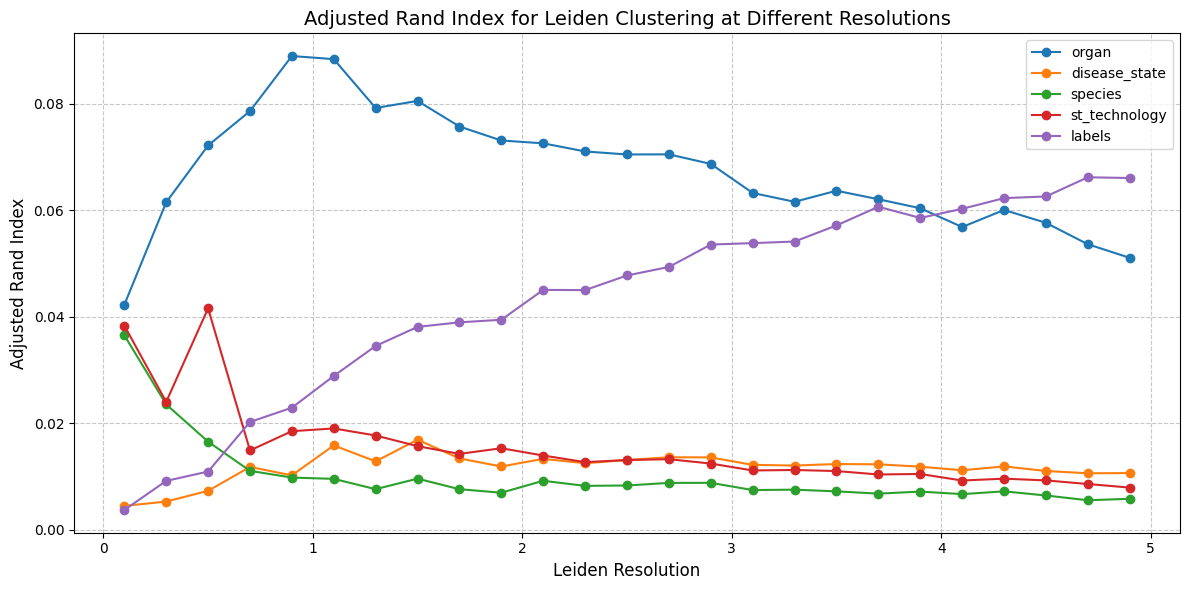

In [76]:
# Run for different resolutions of Leiden clustering with step of 0.2 and store clustering results. Then calculate ARI for each resolution.
columns_to_use = ['organ', 'disease_state', 'species', 'st_technology', 'labels']

resolutions = np.arange(0.1, 5.1, 0.2)
resolutions = np.round(resolutions, 1)  # Ensure consistent decimal precision

ari_results_vae = {col: [] for col in columns_to_use}

# Use tqdm to show progress with a descriptive message
for resolution in tqdm(resolutions, desc="Running Leiden clustering at different resolutions"):
    sc.tl.leiden(vae_adata, resolution=resolution, key_added=f'leiden_{resolution:.1f}')
    leiden_labels = vae_adata.obs[f'leiden_{resolution:.1f}'].astype(int).values
    
    for col in columns_to_use:
        if col in vae_adata.obs.columns and vae_adata.obs[col].notna().sum() > 0:
            col_labels = vae_adata.obs[col].astype('category').cat.codes
            mask = col_labels != -1
            if mask.sum() > 0:
                ari = adjusted_rand_score(col_labels[mask], leiden_labels[mask])
                ari_results_vae[col].append(ari)
            else:
                ari_results_vae[col].append(np.nan)
        else:
            ari_results_vae[col].append(np.nan)

# Plot ARI results
plt.figure(figsize=(12, 6))
for col in columns_to_use:
    plt.plot(resolutions, ari_results_vae[col], marker='o', label=col)

plt.xlabel("Leiden Resolution", fontsize=12)
plt.ylabel("Adjusted Rand Index", fontsize=12)
plt.title("Adjusted Rand Index for Leiden Clustering at Different Resolutions", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()
